In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as spsp
import time
plt.style.use("Solarize_Light2")

# TP 1

## Exercice 1 
#### *(énergie rayonnante d'un corps noir)*

In [2]:
## Constantes physiques

# vitesse de la lumière dans le vide
C0 = 2.997e8
# constante de Planck
h = 6.625e-34
# constante de Boltzmann
k = 1.38e-23
# indice de réfraction du milieu (le vide)
n = 1
# T - température absolue de la surface du corps noir (K)
T = np.arange(300, 850, 50)

### Fonction nécessaires

In [3]:
def Emmitance(lamb, T):
    return (2*np.pi*h*C0**2)/(n**2*lamb**5)*1/(np.exp(h*C0/(n*k*T*lamb)) - 1)

In [4]:
def SectionDoree(f, a, b, Nmax, epsilon = 0):    
    
    r = (1 + np.sqrt(5))/2
    i = 0
    
    while np.abs(f(a, t) - f(b, t)) > epsilon and (i < Nmax):
        x1 = a + (b-a)/r**2
        x2 = a + (b-a)/r
        
        if f(x1,t) > f(x2,t):
            b = x2
        elif f(x1,t) < f(x2,t):
            a = x1
        else:
            a = x1
            b = x2 
        i+=1
            
    return a

***Commentaire:*** Pour appliquer cet algorithme, on suppose que la fonction sur l'intervalle donné soit unimodale.

### Question 1. et 2. -- Traçage des fonctions pour les differentes valeurs de T(K) et la recherche des points de maximisation

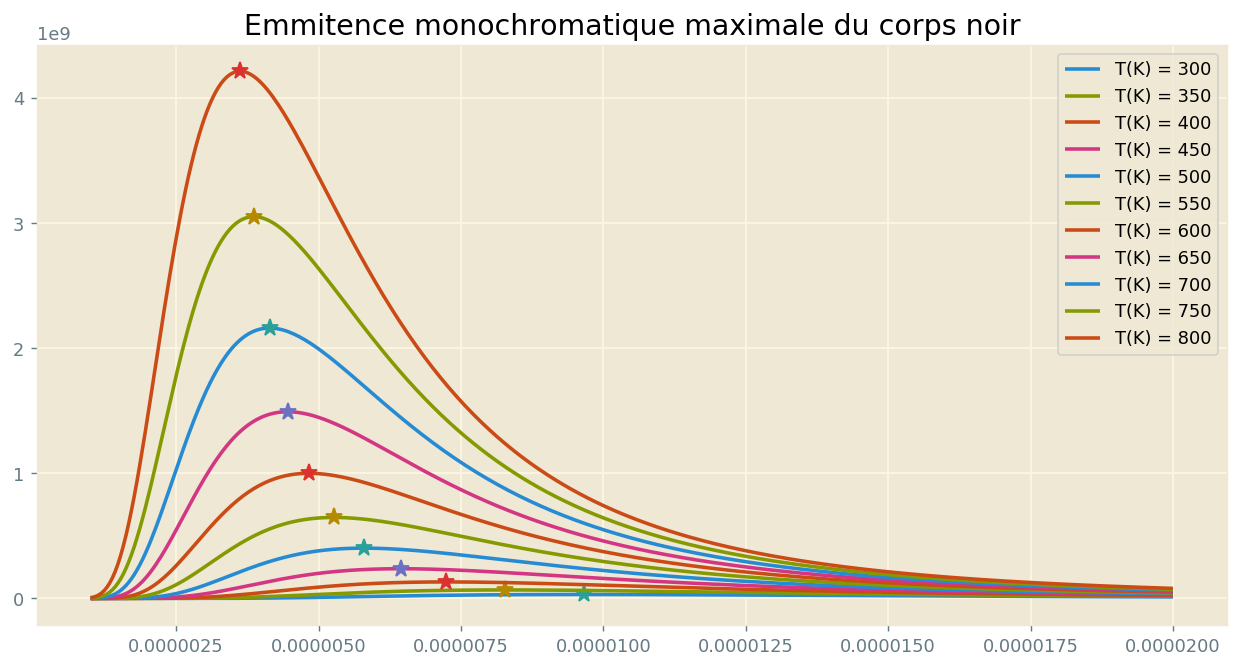

In [5]:
L = np.linspace(10e-7, 2e-5, 400)
fig = plt.subplots(figsize = (12, 6), dpi =128)
plt.title("Emmitence monochromatique maximale du corps noir")

for t in T:
    MaxPoint = SectionDoree(Emmitance, L[0], L[-1], 100)
    plt.plot(L, Emmitance(L, t), label = "T(K) = {:d}".format(t))
    plt.plot(MaxPoint, Emmitance(MaxPoint, t), "*", markersize = 10)
plt.legend();

### Question 3.  -- Verification des lois de Wien

A =  0.002897772578773615
B =  1.285691614517808e-05


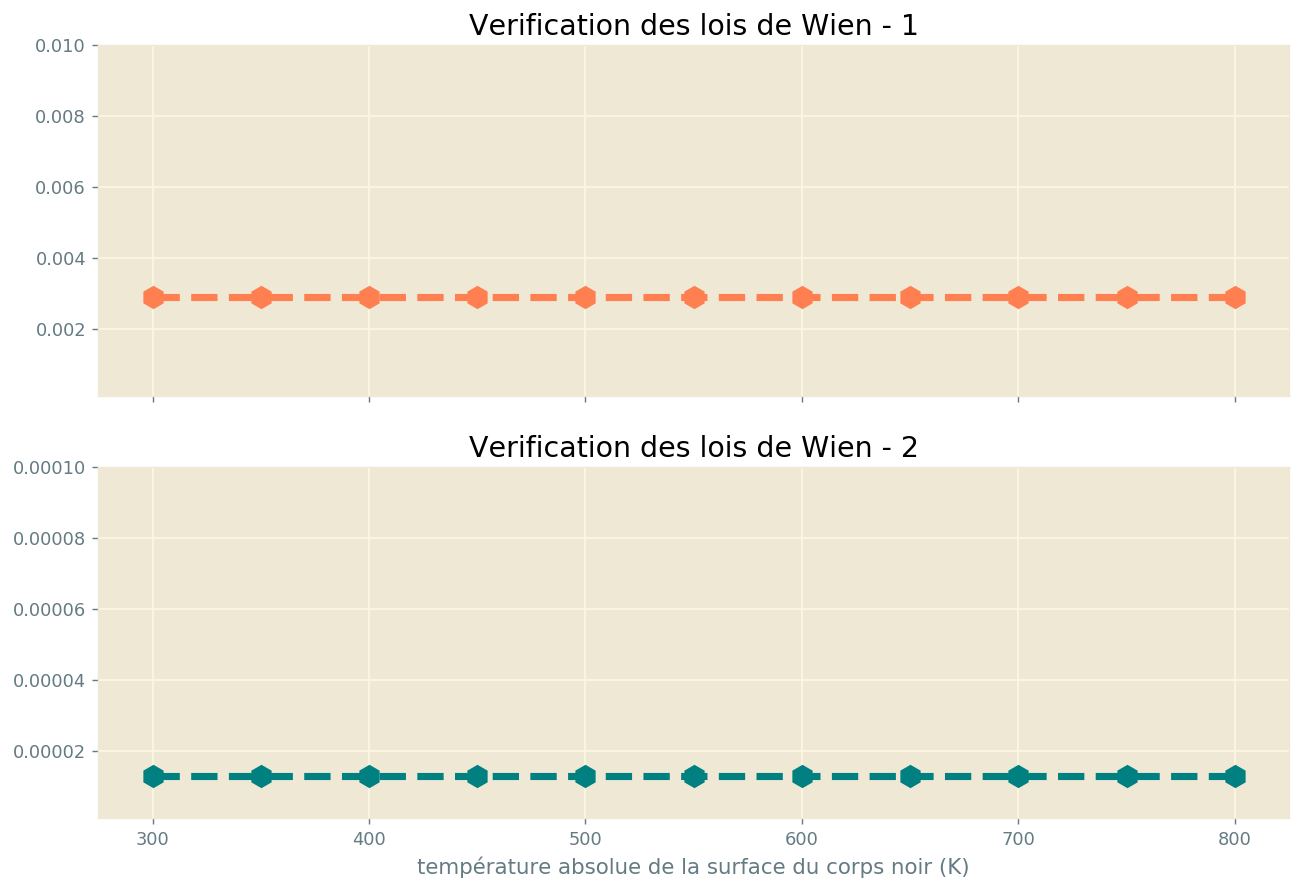

In [6]:
Wien1 = []
Wien2 = []

for t in T:
    MaxPoint = SectionDoree(Emmitance, L[0], L[-1], 100)
    Wien1.append(MaxPoint*t)
    Wien2.append(Emmitance(MaxPoint, t)/t**5)
    
fig, axs = plt.subplots(2, 1, figsize = (12, 8), dpi =128, sharex = True)
axs[0].set_ylim([1e-4, 1e-2])
axs[0].set_title("Verification des lois de Wien - 1")
axs[0].plot(T, Wien1, "--h", color = "coral", linewidth = 4, markersize = 12)
axs[1].set_ylim([1e-6, 1e-4])
axs[1].set_title("Verification des lois de Wien - 2")
plt.xlabel("température absolue de la surface du corps noir (K)")
axs[1].plot(T, Wien2, "--h", color = "teal", linewidth = 4, markersize = 12);
print("A = ", Wien1[-1])
print("B = ", Wien2[-1])

***Commentaire:*** On voit bien que les lois de Wien sont vérifiés. 
$$
\lambda^{*}T = \mathbf{const} \approx 0.00289
$$ 
et
$$
\frac{M(\lambda^{*})}{T^{5}} = \mathbf{const} \approx 1.2857e-05
$$

---
- - -

## Exercice 2
#### *(méthodes de type gradient pour des fonctions quadratique)*

In [18]:
# initialisation
def matrix_A(N):
    A = np.eye(N)*4    
    di = np.diag_indices_from(A)
    A[di[0][:-1],di[1][1:]] = -2
    A[di[0][1:],di[1][:-1]] = -2
    return A
def sparse_matrix_A(N):
    subDiag = np.ones(N-1)*-2
    mainDiag = np.ones(N)*4
    di = [subDiag, mainDiag, subDiag]
    A = spsp.diags(di, [-1, 0, 1])
    return A

N = 2
A = matrix_A(N)
A = sparse_matrix_A(N)
b = np.ones(N)

print("matrice A:\n", A.toarray())
print("vecteur b:\n", b)

matrice A:
 [[ 4. -2.]
 [-2.  4.]]
vecteur b:
 [1. 1.]


- - -
#### Fonctions auxiliaire *J* - à minimiser; et *gradient* - pour trouver le gradient d'une fonction quelconque en un point donné

In [19]:
# fonction à minimiser
def J(x):
    assert len(x) == len(b), "Wrong dimensions"
    return 1/2*A@x@x - b@x

def gradient(func, X, epsilon = 0.000001):
    N = len(X)
    grad = np.zeros(N)
    Xeps = np.zeros(N)
    for i in range(N):
        Xeps[i] = epsilon
        grad[i] = (func(X + Xeps) - func(X - Xeps))/(2*epsilon)
        Xeps[i] = 0
    return grad

In [20]:
X = np.array([8, 99])
gradient(J, X)

array([-167.00000015,  378.99999916])

- - -

### Question 1. -- Représentation d'une fonction dans le cas n = 2

In [22]:
# on fait une fonction pour faire une jolie graphique de la fonction 
# avec lignes de niveau et gradient pour N = 2
def ContourPlusGradient(func, argmin=-10, argmax=10, points=12, scale = 500, 
                        axs=axs, contour = True, grad = True, colorbar=True):
    xx = np.linspace(argmin, argmax, points)
    XX, YY = np.meshgrid(xx, xx)

    plot2d = np.zeros((points, points))

    # gradients
    dJdx1 = np.zeros((points, points))
    dJdx2 = np.zeros((points, points))

    for j in range(points):
        for i in range(points):
            plot2d[j,i] = func([xx[j], xx[i]])
            dJdx1[i,j] = gradient(func, [xx[j], xx[i]])[0]
            dJdx2[i,j] = gradient(func, [xx[j], xx[i]])[1]
    
    
    im = axs.imshow(plot2d, origin='lower', cmap='plasma', 
                    extent = [argmin, argmax, argmin, argmax], 
                    interpolation = 'bilinear')
    if contour:
        axs.contour(XX, YY, plot2d, colors = "silver", linestyles = "dashed")
    if grad:
        axs.quiver(XX, YY, dJdx1, dJdx2, units = "width", 
                   color = "c", scale = scale, width = 0.008)
        
    axs.set_aspect("equal")
    plt.xlabel("x1");
    plt.ylabel("x2");
    if colorbar:
        plt.colorbar(im);

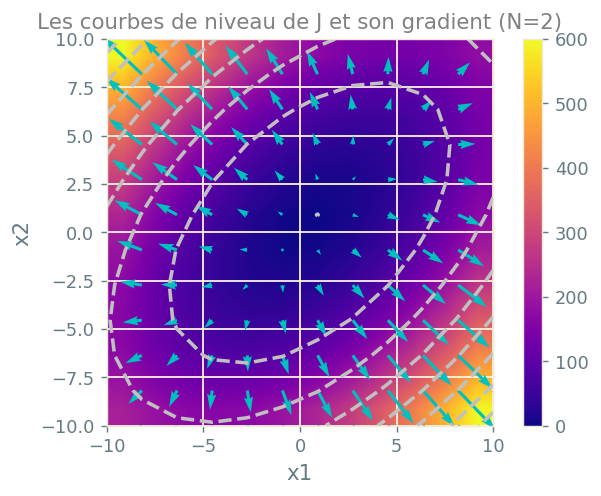

In [23]:
fig, axs = plt.subplots(figsize = (6,4), dpi = 128)
plt.title("Les courbes de niveau de J et son gradient (N=2)", 
          fontsize = 12, color = "gray")
ContourPlusGradient(J, axs=axs)

- - -

### Question 2. -- Verification numérique du fait, que An est définie positive

In [117]:
Ns = [2, 4, 5, 8, 10, 15, 20]
vps = {}

for Nk in Ns:
    A = matrix_A(Nk)
    vp, vect = np.linalg.eig(A)
    vps["N={:d}".format(Nk)] = vp

print("Dictionnaire des valeurs propres de An pour différentes valeurs de N.\n\n", 
      vps)
print("Vérification de la positivité des valeurs propres de A\n")
for i in Ns:
    print("N={:d}: ".format(i), vps["N={:d}".format(i)]>=0)

Dictionnaire des valeurs propres de An pour différentes valeurs de N.

 {'N=2': array([6., 2.]), 'N=4': array([7.23606798, 5.23606798, 0.76393202, 2.76393202]), 'N=5': array([7.46410162, 6.        , 4.        , 0.53589838, 2.        ]), 'N=8': array([7.75877048, 7.06417777, 6.        , 4.69459271, 3.30540729,
       0.24122952, 0.93582223, 2.        ]), 'N=10': array([7.83797189, 7.36501413, 6.61944294, 5.66166005, 4.56925935,
       3.43074065, 0.16202811, 0.63498587, 1.38055706, 2.33833995]), 'N=15': array([7.92314112, 7.69551813, 7.32587845, 6.82842712, 6.22228093,
       5.53073373, 4.78036129, 4.        , 3.21963871, 0.07685888,
       0.30448187, 0.67412155, 1.17157288, 2.46926627, 1.77771907]), 'N=20': array([7.9553233 , 7.82229122, 7.60387547, 7.3049551 , 6.93220749,
       6.49395921, 6.        , 5.4613641 , 4.89008374, 4.29892037,
       3.70107963, 3.10991626, 2.5386359 , 0.0446767 , 0.17770878,
       0.39612453, 0.6950449 , 1.06779251, 1.50604079, 2.        ])}
Vérificatio

***Conclusion:*** Pour vérifier numériquement que An est défini positif, il a été décidé de calculer ses valeurs propres pour différentes valeurs de N. Nous voyons clairement que toutes les valeurs propres pour chaque N sont supérieures ou égales à zéro, on peut donc conclure que A est défini positif.

- - -

### Question 3. -- La méthode du gradient

### La méthode du gradient à pas fixe

In [31]:
def Gradient_descent_fixed(N, p, x0, func, 
                           epsilon=0.001, Iterations = 4004, plot = False):
    # initialisation
    x_old = np.random.normal(size = N)
    x_new = x0
    i = 0
    routeF = np.array([func(x0)])
    routeX = np.array([x0])
    
    # la boucle principal
    while np.linalg.norm(x_old-x_new) > epsilon and i < Iterations:
        x_old = np.copy(x_new)           
        d = -1*gradient(func, x_old)
        x_new = x_old + p*d
        
        routeF = np.append(routeF, func(x_new))
        routeX = np.concatenate((routeX, [x_new]))
        i+=1
    
    # plot pour voir la route du gradient
    if plot:
        i+=1
        # on calcule les erreurs sur chaque pas
        errors = np.zeros(i)
        for k in range(i):
            errors[k] = np.linalg.norm(routeX[k] - x_new)      
        
        xx = np.arange(0, i, 1)
        
        fig,axs = plt.subplots(2, 1, figsize = (12, 6), dpi =128, sharex = True)
        axs[0].set_title("Valeurs de la fonction"
                         " évaluée à chaque pas de gradient à pas fixe")
        axs[0].plot(xx, routeF, "--", color = "coral", linewidth = 2)
        axs[1].set_title("Erreurs - Log scale")
        axs[1].set_yscale("log")
        axs[1].plot(xx, errors, "--", color = "teal", linewidth = 2)
        plt.xlabel("Iteration");
    
    return x_new, routeF, routeX

[0.50240563 0.50240563]


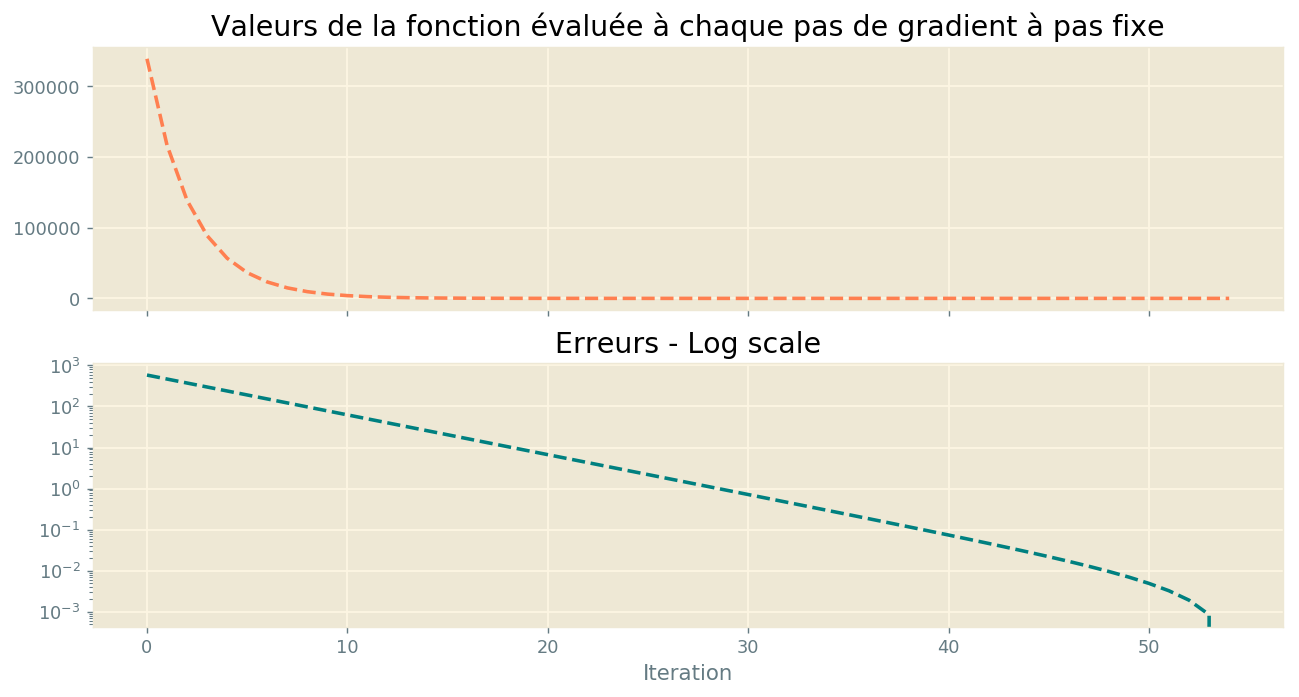

In [32]:
A = sparse_matrix_A(N)
x0 = np.array([404, 420])
Pmin, routeF, routeXfix = Gradient_descent_fixed(2, 0.1, x0, J, plot=True)
print(Pmin)

### Comparaison matrice creuse et habituelle

In [29]:
%%time
N = 50
A = matrix_A(N)
b = np.ones(N)
x0 = np.random.normal(loc = 100, scale = 100, size = N)
Pmin = Gradient_descent_fixed(N, 0.1, x0, J, plot=False)
print(Pmin)

(array([ 12.38215472,  24.26475655,  35.64825093,  46.53307987,
        56.91968035,  66.8084826 ,  76.1999085 ,  85.09436999,
        93.49226744, 101.39398823, 108.79990518, 115.71037523,
       122.12573799, 128.04631452, 133.4724061 , 138.40429308,
       142.84223379, 146.78646361, 150.23719405, 153.19461193,
       155.65887873, 157.63012991, 159.10847446, 160.09399443,
       160.58674467, 160.58675259, 160.09401806, 159.10851345,
       157.63018367, 155.65894643, 153.19469256, 150.23728638,
       146.78656625, 142.84234518, 138.40441153, 133.47252982,
       128.04644162, 122.12586654, 115.7105033 , 108.80003082,
       101.39410953,  93.49238257,  85.09447719,  76.20000617,
        66.80856924,  56.91975465,  46.53314071,  35.64829738,
        24.26478792,  12.38217052]), array([1174451.44995856,  247632.96195067,   97506.9942456 , ...,
         -2762.14450229,   -2762.1450415 ,   -2762.14557988]), array([[225.86531162, 196.98970057,  19.99657142, ..., 157.91670115,
        

In [30]:
%%time
N = 50
A = sparse_matrix_A(N)
b = np.ones(N)
x0 = np.random.normal(loc = 100, scale = 100, size = N)
Pmin = Gradient_descent_fixed(N, 0.1, x0, J, plot=False)
print(Pmin)

(array([ 12.51601563,  24.53197085,  36.0478055 ,  47.06345984,
        57.57887481,  67.59399224,  77.10875506,  86.1231075 ,
        94.63699534, 102.65036608, 110.16316913, 117.17535601,
       123.68688057, 129.69769908, 135.20777048, 140.21705649,
       144.72552177, 148.73313405, 152.23986426, 155.24568663,
       157.75057882, 159.75452199, 161.25750087, 162.25950383,
       162.76052293, 162.76055395, 162.25959642, 161.25765362,
       159.7547326 , 157.75084408, 155.24600252, 152.24022599,
       148.73353615, 144.72595814, 140.21752051, 135.20825512,
       129.69819699, 123.6873842 , 117.17585773, 110.16366133,
       102.6508413 ,  94.63744639,  86.12352753,  77.1091377 ,
        67.5943317 ,  57.57916594,  47.06369822,  36.04798752,
        24.53209375,  12.51607755]), array([1188743.10175927,  234168.90450371,   98750.67550967, ...,
         -2762.49340769,   -2762.49341768,   -2762.49342767]), array([[187.93545618, 164.15976511, 185.44305191, ..., -21.4030583 ,
        

***Commentaire:*** Nous voyons que l'utilisation de la matrice creuse ne porte pas de fruit. En outre, l'algorithme est beaucoup plus rapide avec 'ndarray', ce qui est étrange mais peut s'expliquer par une petite taille de la matrice.

### La méthode du gradient à pas optimal

In [35]:
def SectionDoreeForGradStep(func, X, d, a, b, Nmax, epsilon = 0):    
    
    r = (1 + np.sqrt(5))/2
    i = 0
    
    while np.abs(func(X + a*d) - func(X+b*d)) > epsilon and (i < Nmax):
        x1 = a + (b-a)/r**2
        x2 = a + (b-a)/r
        
        if func(X + x1*d) < func(X+x2*d):
            b = x2
        elif func(X + x1*d) > func(X+x2*d):
            a = x1
        else:
            a = x1
            b = x2 
        i+=1
            
    return a

In [36]:
def Gradient_descent_optimal(N, x0, func, 
                             epsilon=0.001, Iterations = 4004, plot = False):
    # initialisation
    x_old = np.random.normal(size = N)
    x_new = np.array(x0)
    i = 0
    routeF = np.array([func(x0)])
    routeX = np.array([x0])
    
    # la boucle principal
    while np.linalg.norm(x_old-x_new) > epsilon and i < Iterations:
        x_old = np.copy(x_new)           
        d = -1*gradient(func, x_old)
        p = SectionDoreeForGradStep(func, x_old, d, -10, 10, 10000)
        x_new = x_old + p*d
        
        routeF = np.append(routeF, func(x_new))
        routeX = np.concatenate((routeX, [x_new]))
        i+=1
    
    # plot pour voir la route du gradient
    if plot:
        i+=1
        # on calcule les erreurs sur chaque pas
        errors = np.zeros(i)
        for k in range(i):
            errors[k] = np.linalg.norm(routeX[k] - x_new)      
        
        xx = np.arange(0, i, 1)
        
        fig,axs = plt.subplots(2, 1, figsize = (12, 6), dpi =128, sharex = True)
        axs[0].set_title("Valeurs de la fonction évaluée"
                         " à chaque pas de gradient à pas optimal")
        axs[0].plot(xx, routeF, "--", color = "coral", linewidth = 2)
        axs[1].set_title("Erreurs - Log scale")
        axs[1].set_yscale("log")
        axs[1].plot(xx, errors, "--", color = "teal", linewidth = 2)
        plt.xlabel("Iteration");
    
    return x_new, routeF, routeX

[0.50003639 0.50003783]


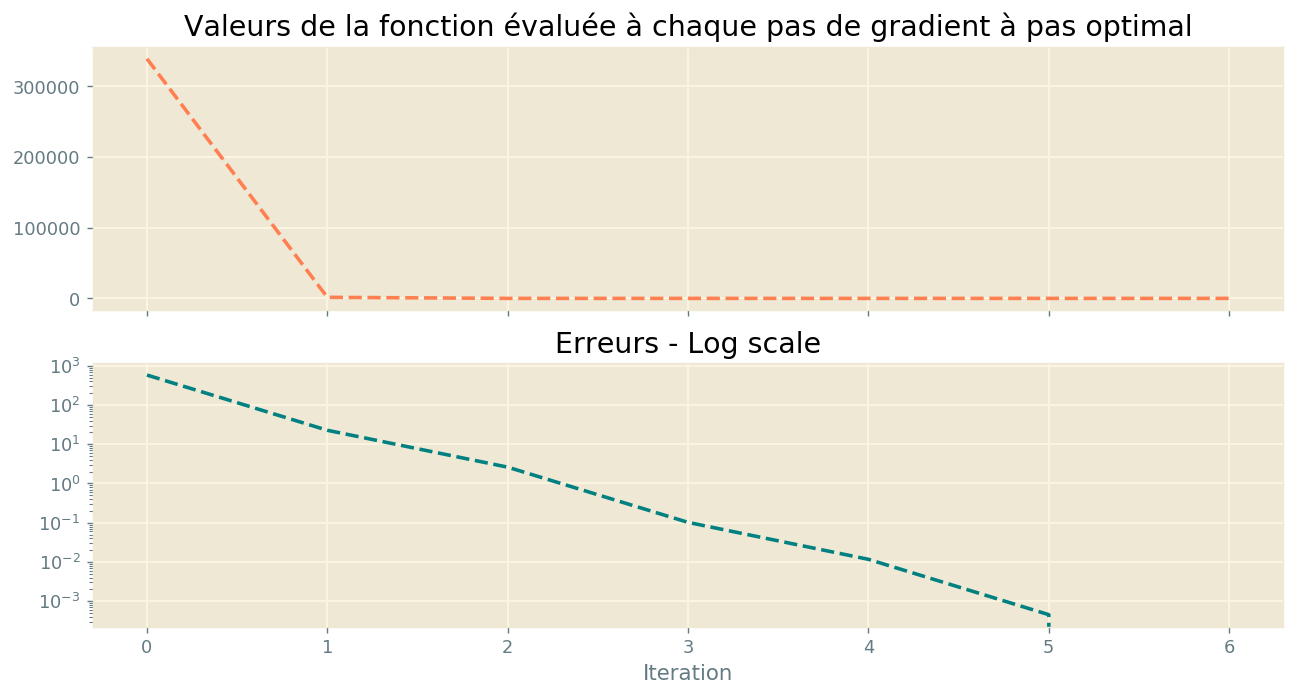

In [37]:
N = 2
A = matrix_A(N)
b = np.ones(N)
Pmin, routeF, routeXopt = Gradient_descent_optimal(2, [404, 420], J, plot=True)
print(Pmin)

### Les routes des méthodes

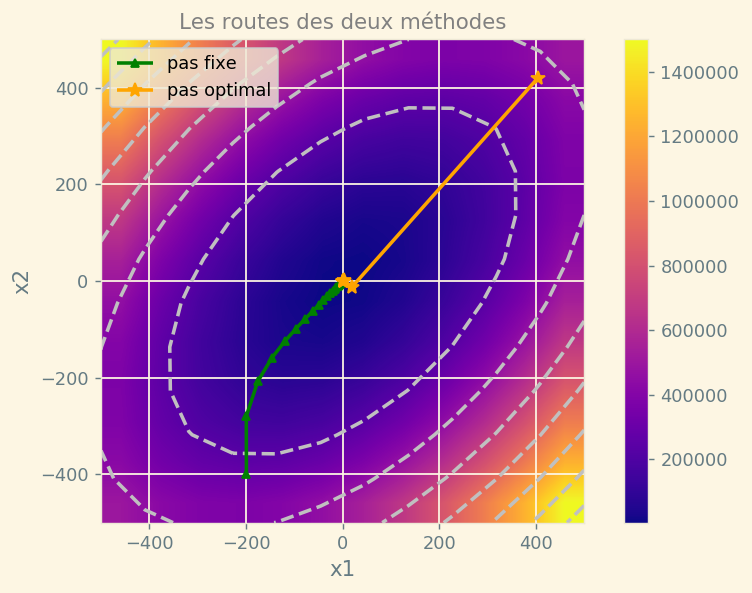

In [123]:
# la taille de pavé est un peu plus grande pour bien voire les routes
x0 = np.array([-199, -400])
Pmin, routeF, routeXfix = Gradient_descent_fixed(2, 0.1, x0, J, plot=False)
Pmin, routeF, routeXopt = Gradient_descent_optimal(2, [404, 420], J, plot=False)

fig, axs = plt.subplots(figsize = (8,5), dpi = 128)
ContourPlusGradient(J, axs=axs, grad = False, argmin = -500, argmax = 500)
plt.title("Les routes des deux méthodes", fontsize = 12, color = "gray")
axs.plot(routeXfix[:,0], routeXfix[:,1], "-^", color = "green", 
         linewidth = 2, markersize = 5, label = "pas fixe");
axs.plot(routeXopt[:,0], routeXopt[:,1], "-*", color = "orange", 
         linewidth = 2, markersize = 8, label = "pas optimal");
plt.legend();

### Tests

CPU times: user 9min 11s, sys: 1min 13s, total: 10min 24s
Wall time: 5min 32s


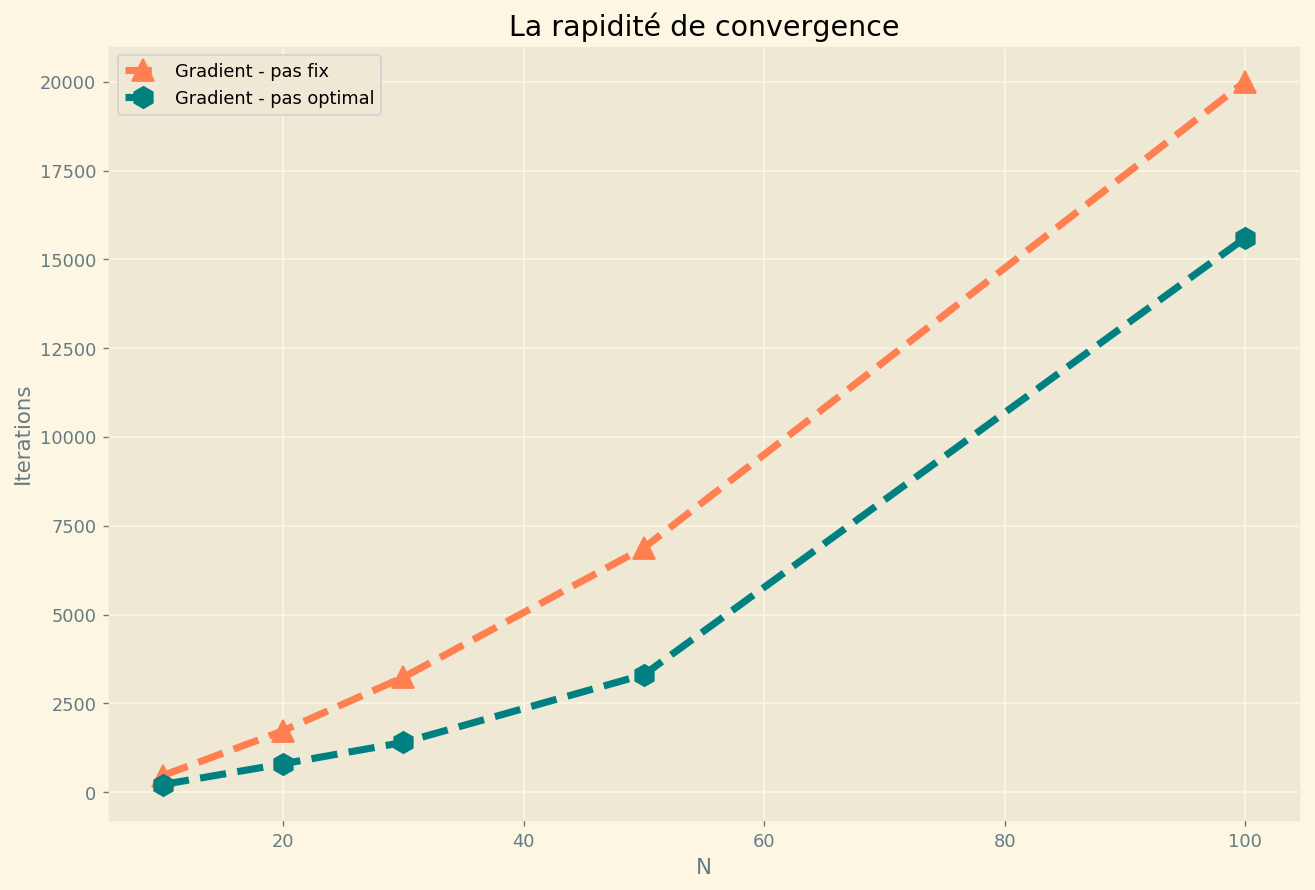

In [38]:
%%time
Ns = [10, 20, 30, 50, 100]
MaxIter = 20000
Niter_fix = []
Niter_opt = []
for N in Ns:
    A = matrix_A(N)
    b = np.ones(N)
    x0 = np.random.normal(100, 100, size = N)
    
    Pmin_fix, r_fix, routeXfix = Gradient_descent_fixed(N, 0.1, 
                                x0, J, Iterations=MaxIter, plot=False)
    Pmin_opt, r_opt, routeXopt = Gradient_descent_optimal(N, 
                                x0, J, Iterations=MaxIter, plot=False)
    
    Niter_fix.append(len(r_fix))
    Niter_opt.append(len(r_opt))

fig = plt.subplots(figsize = (12, 8), dpi =128)
plt.title("La rapidité de convergence")
plt.plot(Ns, Niter_fix, "--^", color = "coral", linewidth = 4, 
         markersize = 12, label = "Gradient - pas fix")
plt.plot(Ns, Niter_opt, "--h", color = "teal", linewidth = 4, 
         markersize = 12,  label = "Gradient - pas optimal")
plt.xlabel("N")
plt.ylabel("Iterations")
plt.legend();

***Commentaire:*** Nous avons obtenu un résultat très intéressant: lorsque N est petit (<~ 50), les convergences de deux méthodes sont comparables. Cependant, avec la croissance de N, pour instance, pour N = 100, on voit que gradient à pas fixe n'arrive pas à converger avec réglage initial.

D'en autre côté, nous voyons que la pente du dernier morceau du graphe de gradient de pas optimal est plus élevée qu'avant. Ainsi, on peut supposer que, pour une valeur encore plus grande de N, un gradient à pas optimal ne sera pas si efficace et la convergence de deux méthodes soit assez proche. Vérifions-le!

Attention, l'exécution de la cellule suivante prendra du temps...

CPU times: user 12min 28s, sys: 2min 29s, total: 14min 58s
Wall time: 7min 32s


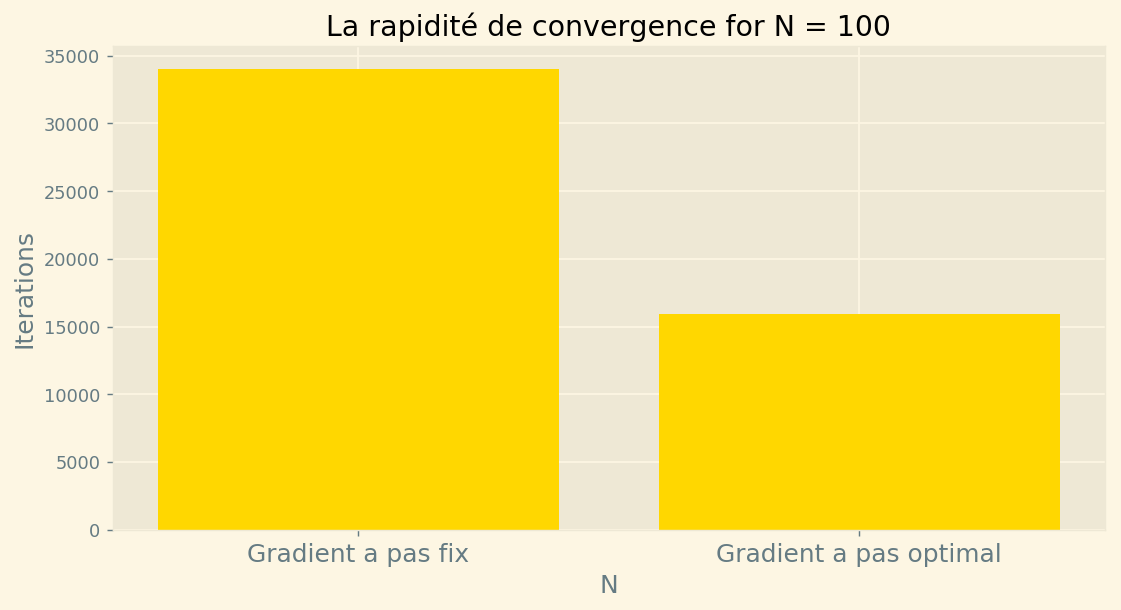

In [124]:
%%time
N = 100
A = matrix_A(N)
b = np.ones(N)
x0 = np.random.normal(100, 100, size = N)

Pmin_fix, r_fix, routeXfix = Gradient_descent_fixed(N, 
                            0.1, x0, J, Iterations = 50000, plot=False)
Pmin_opt, r_opt, routeXopt = Gradient_descent_optimal(N, 
                            x0, J, Iterations = 50000, plot=False)

x = [0, 1]
convs = [len(r_fix), len(r_opt)]
xlabs = ["Gradient a pas fix", "Gradient a pas optimal"]
fig = plt.subplots(figsize = (10, 5), dpi =128)
plt.title("La rapidité de convergence for N = {:d}".format(N))
plt.bar(x, convs, color = "gold")
plt.xticks(labels=xlabs, ticks=x, fontsize = 14)
plt.xlabel("N", fontsize = 14)
plt.ylabel("Iterations", fontsize = 14);

***Conclusion:*** Apparemment, l'hypothèse n'était pas correcte; l'efficacité de gradient à pas optimal est encore plus évidente pour les grandes valeurs de N, cette méthode converge beaucoup plus vite que gradient à pas fix.

In [125]:
print("Gradient à pas fixe - "
      "Vitesse de convergence pour N = {:d}: {:d}\n".format(N, convs[0]))
print("Gradient à pas optimal - "
      "Vitesse de convergence pour N = {:d}: {:d}\n".format(N, convs[1]))

Gradient à pas fixe - Vitesse de convergence pour N = 100: 33992

Gradient à pas optimal - Vitesse de convergence pour N = 100: 15965



# TP 2

## Exercice 1 
#### *(méthode du gradient conjugué)*

In [208]:
N = 2
A = matrix_A(N)
A = sparse_matrix_A(N)
b = np.ones(N)

print("matrice A:\n", A.toarray())
print("vecteur b:\n", b)

matrice A:
 [[ 4. -2.]
 [-2.  4.]]
vecteur b:
 [1. 1.]


In [38]:
# fonction à minimiser et fonctions pour calculer r_k, ro_k 
def J(x):
    assert len(x) == len(b), "Wrong dimensions"
    return 1/2*A@x@x - b@x

def f_r(x):
    assert len(x) == len(b), "Wrong dimensions"
    return A@x - b
def f_ro(r, d):
    assert len(r) == len(d), "Wrong dimensions"
    return -r@d/(A@d@d)

In [39]:
def ConjGradient(N, x0, func, epsilon= 0.001, Iterations = 4004, plot = False):
    # initialisation
    x_old = np.random.normal(size = N)
    x_new = x0
    r_old = f_r(x0)
    r_new = r_old
    d = -r_old
    i = 0
    route = [func(x0)]
    routeX = np.array([x0])
    
    # la boucle principal
    while np.linalg.norm(x_old-x_new) > epsilon and i < Iterations:
        x_old = np.copy(x_new)
        r_old = r_new
        ro = f_ro(r_old, d)
        x_new = x_old + ro*d
        r_new = f_r(x_new)
        beta = (np.linalg.norm(r_new)**2)/(np.linalg.norm(r_old)**2)
        d = -r_new + beta*d
        
        route.append(func(x_new))
        routeX = np.concatenate((routeX, [x_new]))
        i+=1
    
    # plot pour voir la route du gradient
    if plot:
        i+=1
        # on calcule les erreurs sur chaque pas
        errors = np.zeros(i)
        for k in range(i):
            errors[k] = np.linalg.norm(routeX[k] - x_new)      
        
        xx = np.arange(0, i, 1)
        
        fig,axs = plt.subplots(2, 1, figsize = (12, 6), dpi =128, sharex = True)
        axs[0].set_title("Valeurs de la fonction" 
                         " évaluée à chaque pas de gradient conjugué")
        axs[0].plot(xx, route, "--", color = "coral", linewidth = 2)
        axs[1].set_title("Erreurs - Log scale")
        axs[1].set_yscale("log")
        axs[1].plot(xx, errors, "--", color = "teal", linewidth = 2)
        plt.xlabel("Iteration");
    
    return x_new, route, routeX

[0.5 0.5]


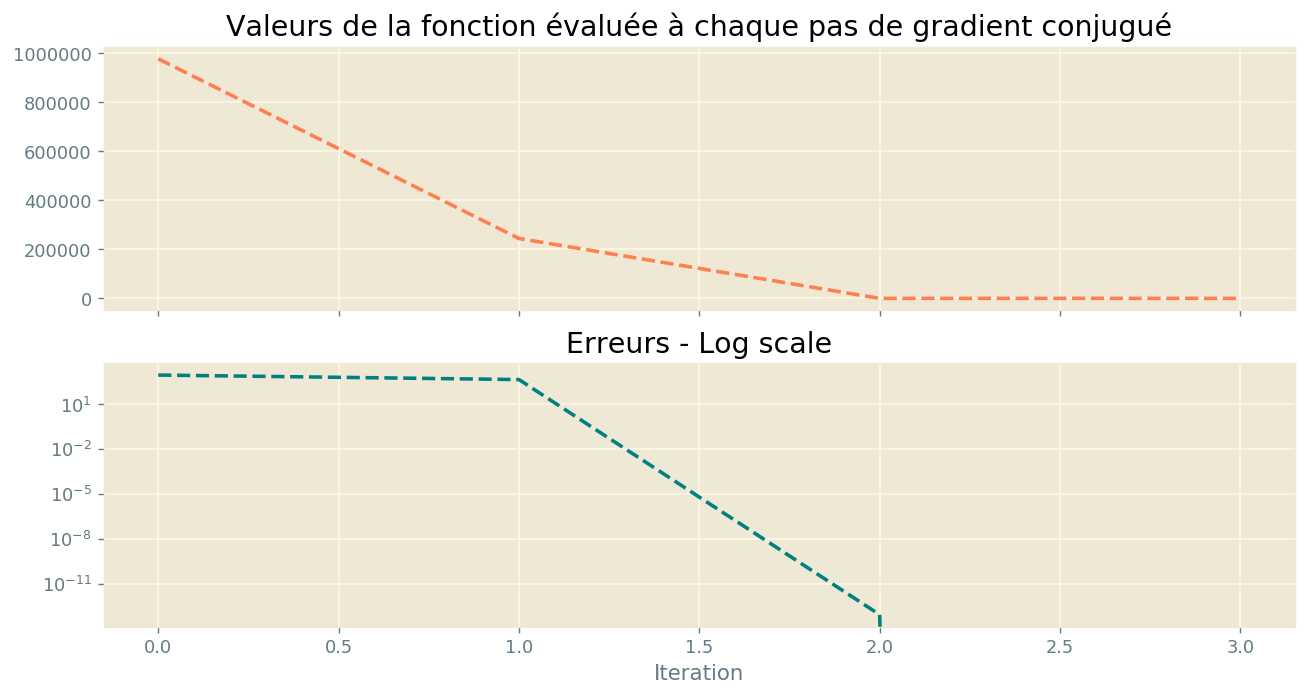

In [40]:
x0 = np.array([404, 808])
Pmin, route, routeX = ConjGradient(2, x0, J, plot=True)
print(Pmin)

### Tests

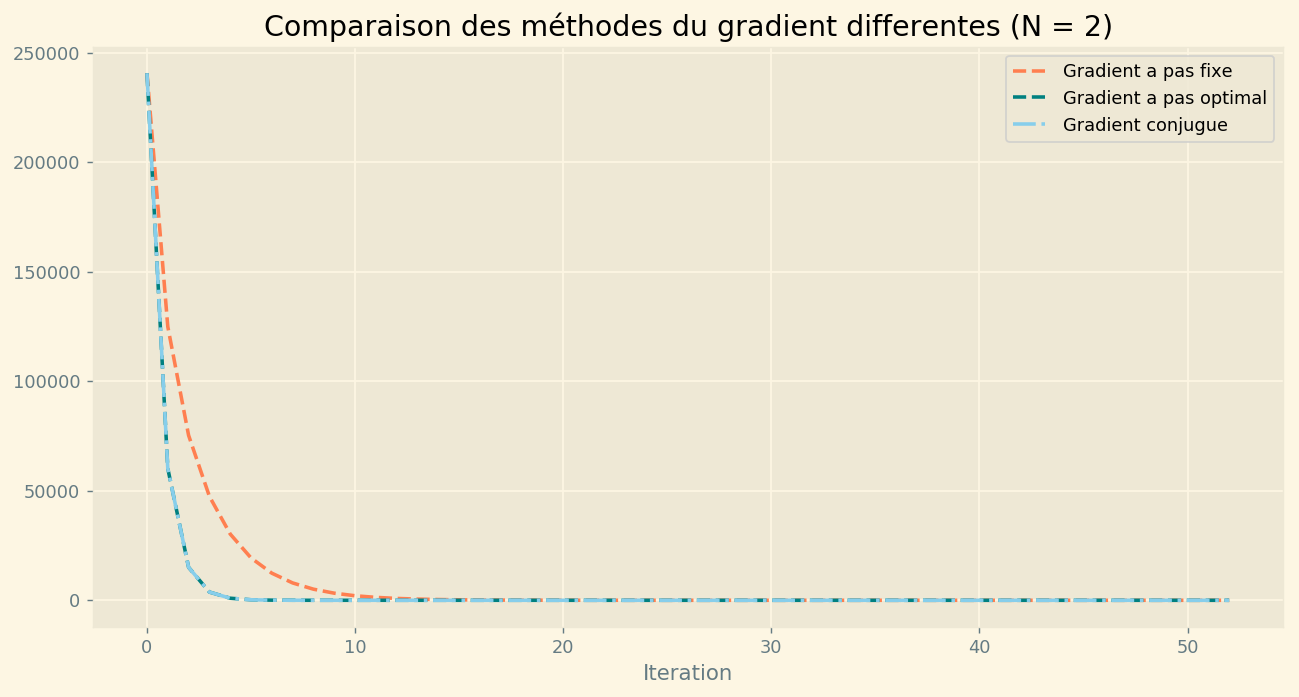

In [147]:
MaxIter = 4000
Pmin_fix, r_fix, routeXfix = Gradient_descent_fixed(N, 
                            0.1, x0, J, Iterations=MaxIter, plot=False)
Pmin_opt, r_opt, routeXopt = Gradient_descent_optimal(N, 
                            x0, J, Iterations=MaxIter, plot=False)
Pmin_conj, r_conj, routeXconj = Gradient_descent_optimal(N, 
                            x0, J, Iterations=MaxIter, plot=False)

convlengths = np.array([len(r_fix), len(r_opt), len(r_opt)])
convroutes = np.array([r_fix, r_opt, r_opt])

# on fait le ménage pour avoir jolie graphique
maxconv = np.max(convlengths)
for i, conv in enumerate(convlengths):
    if conv < maxconv:
        dummy = np.zeros(maxconv)
        dummy[:conv] = convroutes[i]
        dummy[conv:] = convroutes[i][-1]
        convroutes[i] = np.copy(dummy)
        
xx = np.arange(0, maxconv, 1)
fig = plt.subplots(figsize = (12, 6), dpi =128)
plt.title("Comparaison des méthodes du gradient differentes (N = 2)")
plt.plot(xx, convroutes[0], "--", color = "coral", 
         linewidth = 2, label = "Gradient a pas fixe")
plt.plot(xx, convroutes[1], "--", color = "teal", 
         linewidth = 2, label = "Gradient a pas optimal")
plt.plot(xx, convroutes[2], "-.", color = "skyblue", 
         linewidth = 2, label = "Gradient conjugue")
plt.xlabel("Iteration")
plt.legend();

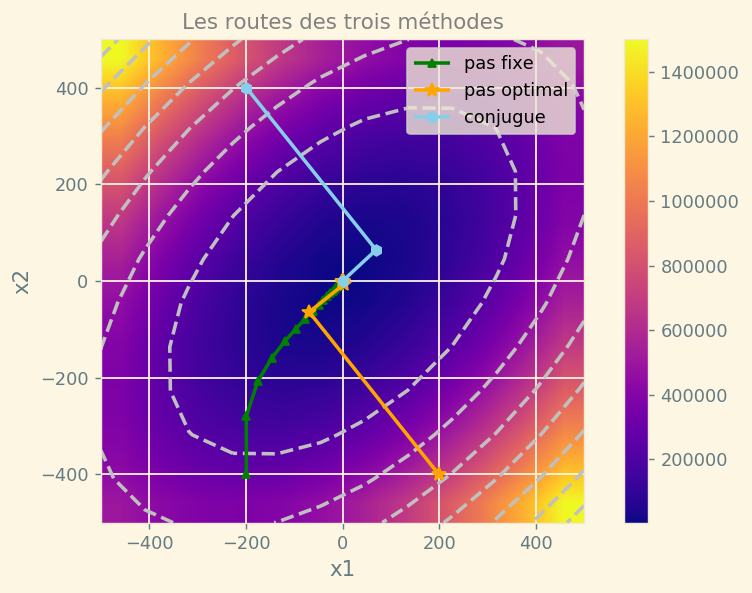

In [149]:
# On applique la même technique qu'avant; 
# la taille de pavé est un peu plus grande pour bien voire les routes
N = 2
x0 = np.array([-199, -400])
x0_o = np.array([199, -400])
x0_c = np.array([-199, 400])
Pmin, routeF, routeXfix = Gradient_descent_fixed(N, 0.1, x0, J, plot=False)
Pmin, routeF, routeXopt = Gradient_descent_optimal(N, x0_o, J, plot=False)
Pmin, route, routeXconj = ConjGradient(N, x0_c, J, plot=False)

fig, axs = plt.subplots(figsize = (8,5), dpi = 128)
ContourPlusGradient(J, axs=axs, grad = False, argmin = -500, argmax = 500)
plt.title("Les routes des trois méthodes", fontsize = 12, color = "gray")
axs.plot(routeXfix[:,0], routeXfix[:,1], "-^", color = "green", 
         linewidth = 2, markersize = 5, label = "pas fixe");
axs.plot(routeXopt[:,0], routeXopt[:,1], "-*", color = "orange", 
         linewidth = 2, markersize = 8, label = "pas optimal");
axs.plot(routeXconj[:,0], routeXconj[:,1], "-h", color = "skyblue", 
         linewidth = 2, markersize = 6, label = "conjugue");
plt.legend();

***Commentaire:*** Pour le cas $N = 2$ on affirm que le gradient conjugué est aussi rapide que le gradient à pas optimal et donne déjà une solution proche après 3-5 itérations.

CPU times: user 9min 3s, sys: 1min 16s, total: 10min 19s
Wall time: 5min 24s


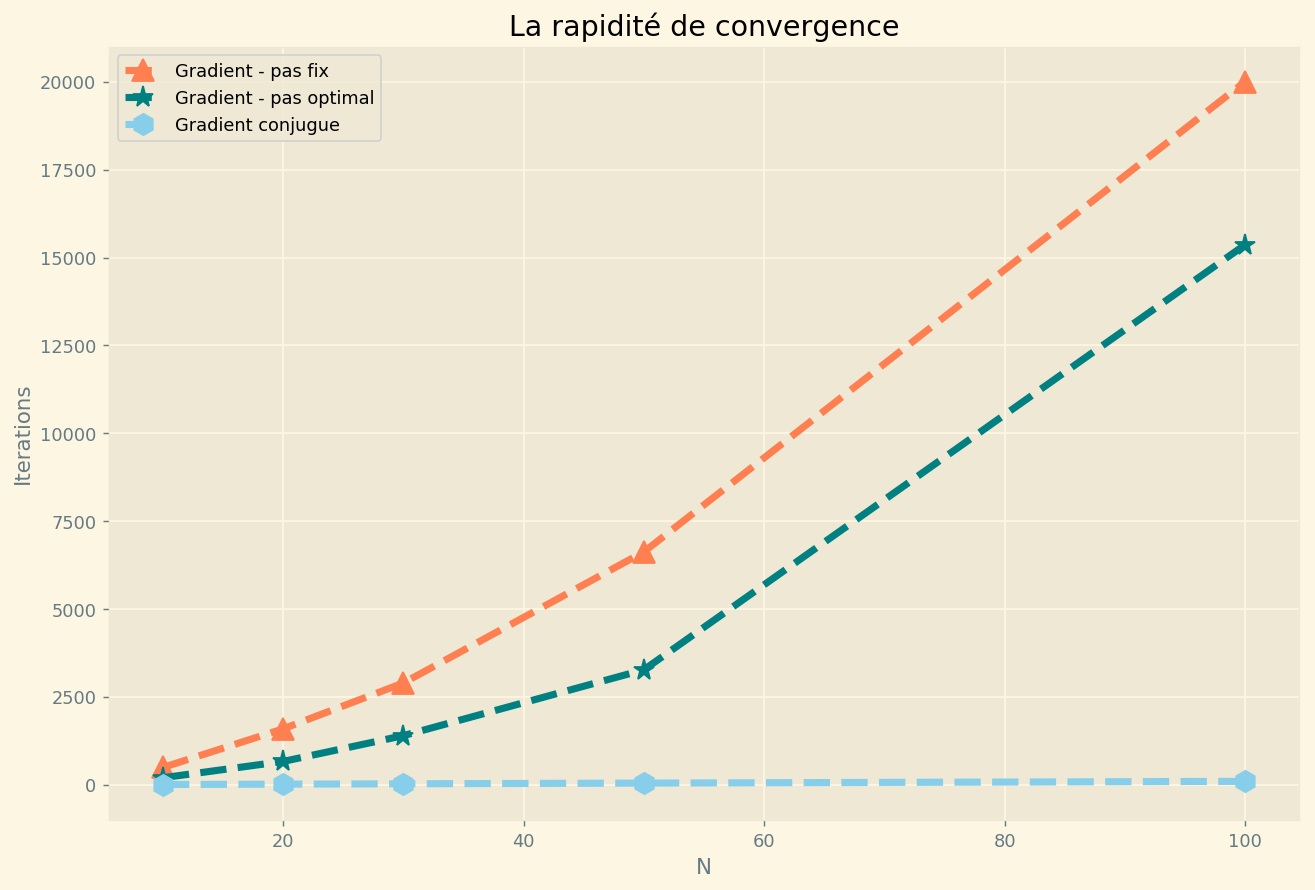

In [134]:
%%time
# On compare la convergence des méthodes pour les differentes valeurs de N
Ns = [10, 20, 30, 50, 100]
MaxIter = 20000
Niter_fix = []
Niter_opt = []
Niter_conj = []

for N in Ns:
    A = matrix_A(N)
    b = np.ones(N)
    x0 = np.random.normal(100, 100, size = N)
    
    Pmin_fix, r_fix, routeXfix = Gradient_descent_fixed(N, 
                                0.1, x0, J, Iterations=MaxIter, plot=False)
    Pmin_opt, r_opt, routeXopt = Gradient_descent_optimal(N, 
                                x0, J, Iterations=MaxIter, plot=False)
    Pmin_conj, r_conj = ConjGradient(N, 
                                x0, J, Iterations=MaxIter, plot=False)
    
    Niter_fix.append(len(r_fix))
    Niter_opt.append(len(r_opt))
    Niter_conj.append(len(r_conj))

fig = plt.subplots(figsize = (12, 8), dpi =128)
plt.title("La rapidité de convergence")
plt.plot(Ns, Niter_fix, "--^", color = "coral", linewidth = 4, 
         markersize = 12, label = "Gradient - pas fix")
plt.plot(Ns, Niter_opt, "--*", color = "teal", linewidth = 4, 
         markersize = 12,  label = "Gradient - pas optimal")
plt.plot(Ns, Niter_conj, "--h", color = "skyblue", linewidth = 4, 
         markersize = 12,  label = "Gradient conjugue")
plt.xlabel("N")
plt.ylabel("Iterations")
plt.legend();

***Commentaire:*** Cependant, en étudiant des cas avec des valeurs plus grandes de N, on voit bien que le gradient conjugué est la plus efficace entre trois méthodes de descente de gradient.

- - -
- - -

## Exercice 2
#### *(cas de fonctions plus générales)*

### Question 1. -- Étude théorique

***(a)***

Pour trouver les points critiques de *f(x,y)* on commence par calculer des dérivées partielles:
$$
\frac {\partial f}{\partial x} = 2x - 2 + 20(x^2 - y)\cdot 2x \text{,} \\
\frac {\partial f}{\partial y} = 20y - 20x^2
$$
Maintenant on veut résoudre système suivant:
$$
\begin{cases}
\frac {\partial f}{\partial x} = 0 & (1)\\
\frac {\partial f}{\partial y} = 0 & (2) 
\end{cases}
$$
$$$$

Equation *(2)* nous donne $y = x^2$; en le mettant dans la première équation *(1)*, on obtient $x^* = 1$, $y^* = 1$.
On calcule $f(x^*, y^*) = 0$ et on peut en effet dire que c'est un minimum globale, car $f(x,y)$ est toujours non-negative, car se compose de deux termes au carré; le point $(x^*, y^*)$ l'annule.

***(b)***

Les dérivées partielles secondes:
$$ 
\frac {\partial^2 f}{\partial x^2} = 2 + 120x^2 - 40y \text{,} \\
\frac {\partial^2 f}{\partial x \partial y} = -40x\text{,} \\
\frac {\partial^2 f}{\partial y^2} = 20
$$
Hessian:
$$
Hess\kern 0.42em f(x^*, y^*) = \begin{pmatrix}
82 & -40 \\
-40 & 20
\end{pmatrix}
$$


- - -

### Question 2. -- Étude numérique

In [214]:
def banana(x):
    return (x[0] - 1)**2 + 10*(x[0]**2 - x[1])**2

***Remarque:*** Remarquons que les implémentations des algorithmes de descente de gradient données précédemment sont toujours valables et peuvent être utilisées pour minimiser toute fonction (qui prend une liste de variables en tant que le vecteur X de même taille N que la matrice A).

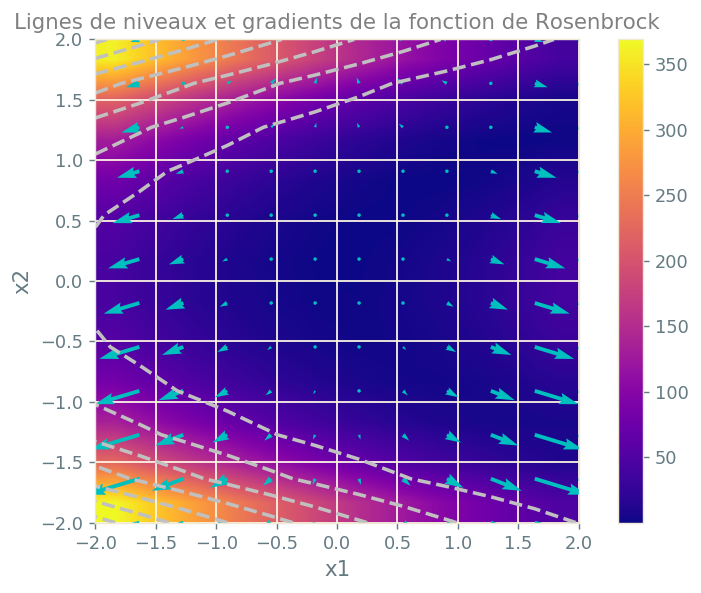

In [215]:
# lignes de niveaux de f; on utilise même logique comme en TP1
points = 12
argmin = -2
argmax = 2

fig, axx = plt.subplots(figsize = (8,5), dpi = 128)
plt.title("Lignes de niveaux et gradients de la fonction de Rosenbrock", 
          fontsize = 12, color = "gray")
ContourPlusGradient(banana, axs=axx, 
                    argmin = argmin, argmax = argmax, points = points, scale = None)

[ 0.77896321 -1.18397867]


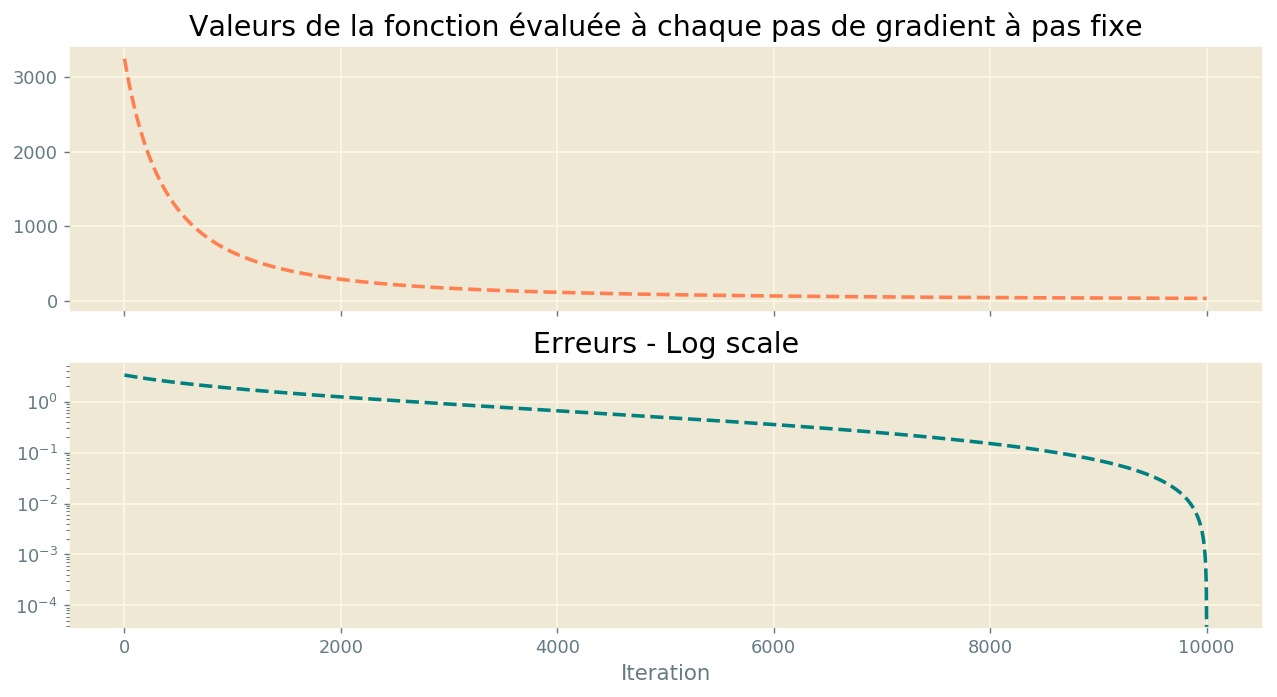

In [216]:
Pmin, route, routeXfix = Gradient_descent_fixed(2, 
                        0.000001, [4, -2], banana, 
                        plot=True, epsilon=0.000001, Iterations=10000)
print(Pmin)

[1.05368159 1.11089881]
[[-4.         -2.        ]
 [ 0.09255672 -1.49020055]
 [-7.91900562 62.82484652]
 [-7.92265862 62.82439148]
 [-7.91518159 62.76436455]
 [-7.91884046 62.76390879]
 [-7.91134833 62.7037607 ]
 [-7.91501275 62.70330426]
 [-7.90750453 62.64302449]
 [-7.91117482 62.64256733]]


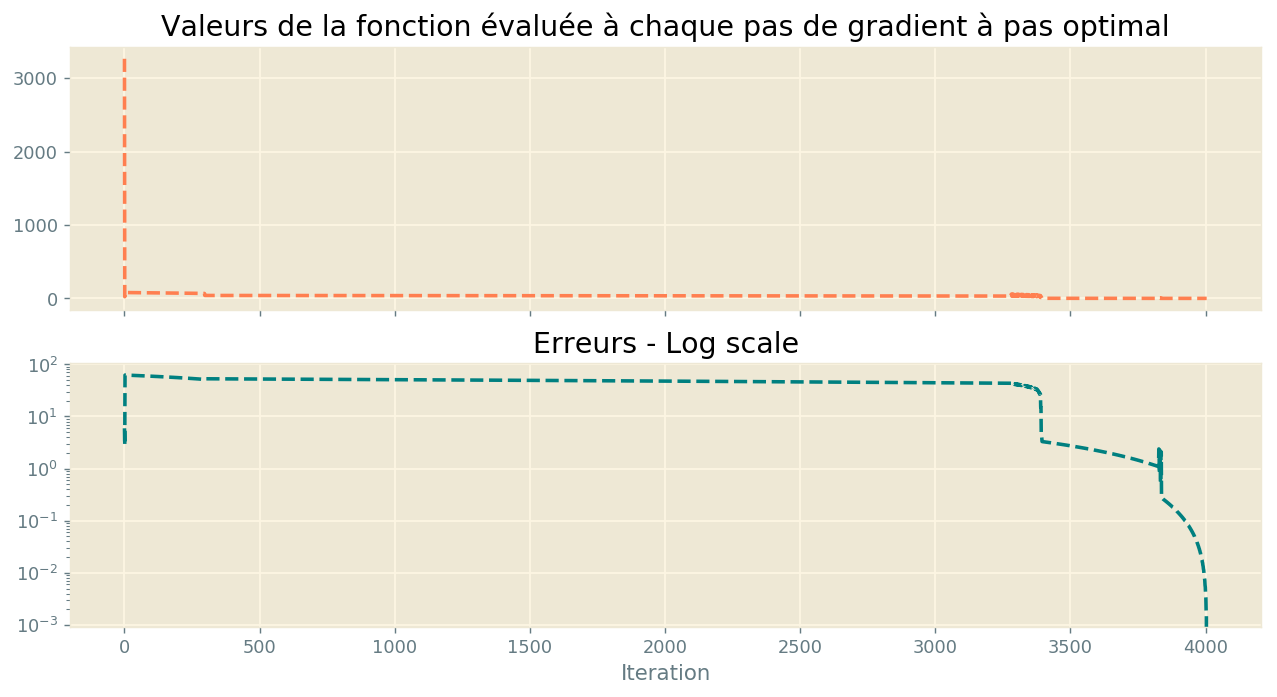

In [217]:
Pmin, route, routeXopt = Gradient_descent_optimal(2, 
                        [-4, -2], banana, 
                        plot=True, epsilon=0.00001)
print(Pmin)
print(routeXopt[:10])

***Commentaire:*** On note une *"bizarerie"* sûr le tracé de l'erreur. Probablement, cela est dû à la forme de la fonction, vérifions-le en regardant la route des $x_k$ sur le graphique suivant.

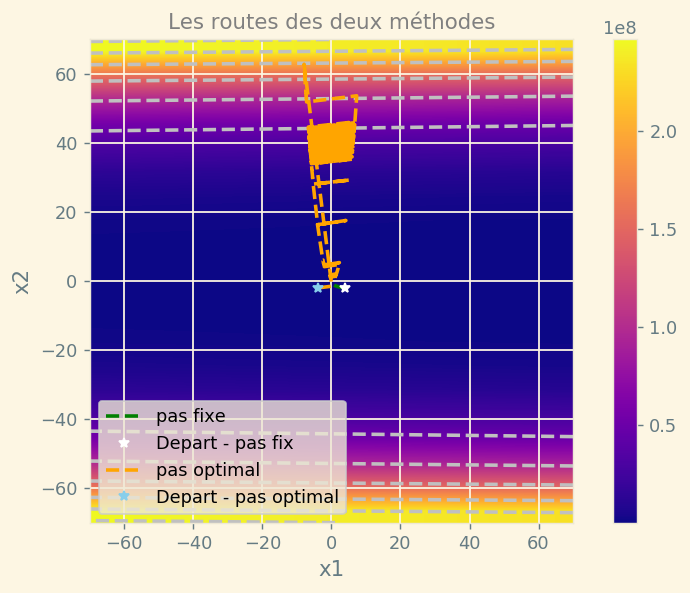

In [161]:
# lignes de niveaux de f; on utilise même logique comme en TP1
points = 20
argmin = -70
argmax = 70

fig, axx = plt.subplots(figsize = (8,5), dpi = 128)
plt.title("Les routes des deux méthodes", fontsize = 12, color = "gray")
ContourPlusGradient(banana, axs=axx, grad = False, 
                    argmin = argmin, argmax = argmax, points = points, scale = None)
axx.plot(routeXfix[:,0], routeXfix[:,1], "--", color = "green", 
         linewidth = 2, label = "pas fixe");
axx.plot(routeXfix[0,0], routeXfix[0,1], "*", color = "white", 
         linewidth = 2, label = "Depart - pas fix")
axx.plot(routeXopt[:,0], routeXopt[:,1], "--", color = "orange", 
        label = "pas optimal");
axx.plot(routeXopt[0,0], routeXopt[0,1], "*", color = "skyblue", 
         label = "Depart - pas optimal")
plt.legend();

***Commentaire:*** Il est facile de remarquer les énormes oscillations de l’itinéraire de la méthode du gradient à pas optimal. Quant à la méthode de gradient à pas fixe, elle n'arrive pas à converger aussi proche qu'avant vers le point de minimisation. On confirme que la forme "banane" de la fonction de Rosenbrock crée beaucoup de difficultés pour les algorithmes de minimisation.

- - -

### Question 3. -- Pour aller plus loin

#### Étude théorique

Cette fois, notre fonction $f$ est:
$$
    f(x, y) = (x - 1)^2 + k(x^2 - y)^2, \quad \text{où} \quad k > 0
$$

***(a)***

Pour trouver les points critiques de *f(x,y)* on commence par calculer des dérivées partielles:
$$
\frac {\partial f}{\partial x} = 2x - 2 + 2k(x^2 - y)\cdot 2x \text{,} \\
\frac {\partial f}{\partial y} = 2k(y - x^2)
$$
Maintenant on veut résoudre système suivant:
$$
\begin{cases}
\frac {\partial f}{\partial x} = 0 & (1)\\
\frac {\partial f}{\partial y} = 0 & (2) 
\end{cases}
$$
$$$$

Equation *(2)* nous donne $y = x^2$; en le mettant dans la première équation *(1)*, on obtient $x^* = 1$, $y^* = 1$. Donc, le point de minimisation n'est pas influencé par la valeur de $k$.
On calcule $f(x^*, y^*) = 0$ et on peut en effet dire que c'est un minimum globale, car $f(x,y)$ est toujours non-negative, car se compose de deux termes au carré; le point $(x^*, y^*)$ l'annule.

***(b)***

Les dérivées partielles secondes:
$$ 
\frac {\partial^2 f}{\partial x^2} = 2 + 12kx^2 - 4ky \text{,} \\
\frac {\partial^2 f}{\partial x \partial y} = -4kx\text{,} \\
\frac {\partial^2 f}{\partial y^2} = 20
$$
Hessian:
$$
Hess\kern 0.42em f(x^*, y^*) = \begin{pmatrix}
82 & -40 \\
-40 & 20
\end{pmatrix}
$$

#### Étude théorique

In [171]:
# deuxième version de la fonction de Rosenbrock
# on considére que k est définie degors de fonction
def banana_na(x):
    return (x[0] - 1)**2 + k*(x[0]**2 - x[1])**2

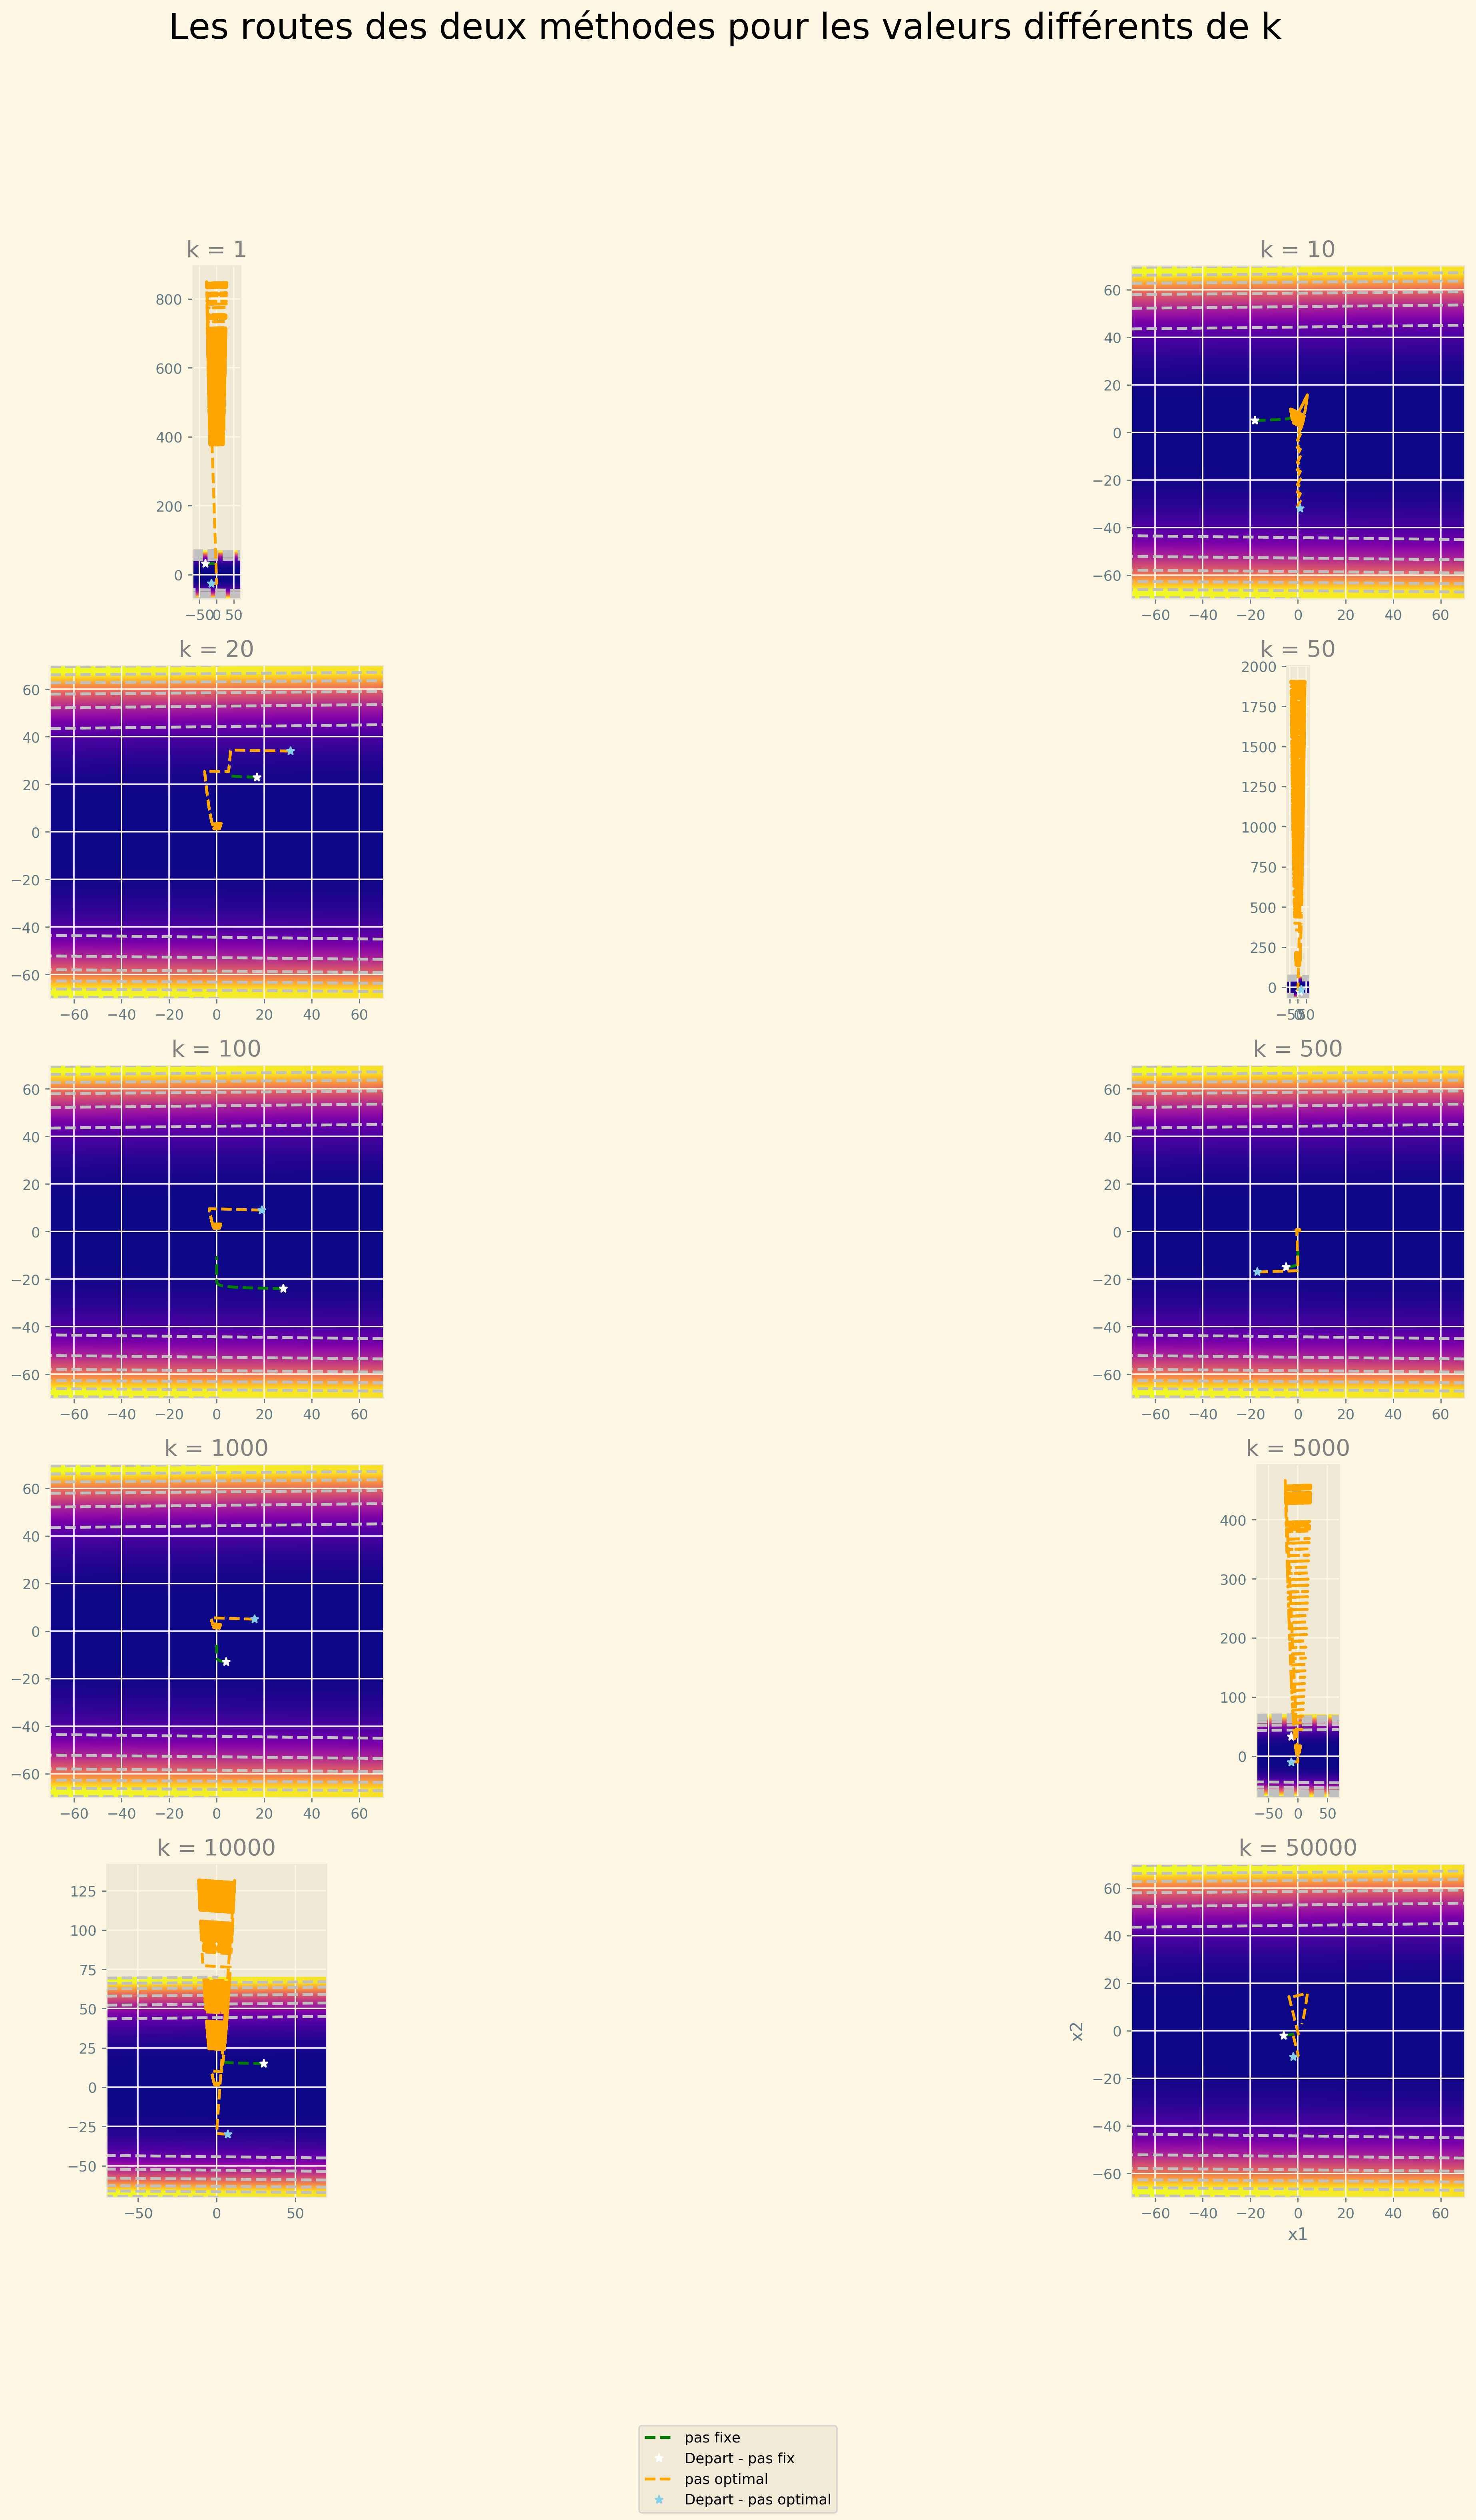

In [210]:
points = 20
argmin = -70
argmax = 70
ks = [1, 10, 20, 50, 100, 500, 1000, 5000, 10000, 50000]
fig, axx = plt.subplots(5, 2, figsize = (25,25), dpi = 256)
fig.suptitle("Les routes des deux méthodes"
             " pour les valeurs différents de k", 
             fontsize = 25, color = "black")
for i in range(len(ks)): 
    
    k = ks[i]
    x0 = np.random.randint(argmin//2, argmax//2, size = 2)
    Pmin, route, routeXfix = Gradient_descent_fixed(2, 
                                    0.00001, x0, banana, 
                                    plot=False, epsilon=0.00001)
    x0 = np.random.randint(argmin//2, argmax//2, size = 2)
    Pmin, route, routeXopt = Gradient_descent_optimal(2, 
                                    x0, banana, plot=False, epsilon=0.00001)
    
    axx[i//2, i%2].set_title("k = {:d}".format(ks[i]), color = "gray")
    ContourPlusGradient(banana, axs=axx[i//2, i%2], 
                        grad = False, argmin = argmin, argmax = argmax, 
                        points = points, scale = None, colorbar = False)
    axx[i//2, i%2].plot(routeXfix[:,0], routeXfix[:,1], "--", color = "green", 
             linewidth = 2, label = "pas fixe");
    axx[i//2, i%2].plot(routeXfix[0,0], routeXfix[0,1], "*", color = "white", 
             linewidth = 2, label = "Depart - pas fix")
    axx[i//2, i%2].plot(routeXopt[:,0], routeXopt[:,1], "--", color = "orange", 
            label = "pas optimal");
    axx[i//2, i%2].plot(routeXopt[0,0], routeXopt[0,1], "*", color = "skyblue", 
             label = "Depart - pas optimal")

handles, labels = axx[-1, -1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center');

***Commentaire:*** On peut remarquer que lorsque $k$ prend des valeurs de plus en plus grandes, les oscillations deviennent de plus en plus faibles ou, plutôt la probabilité d'avoir des fortes oscillations est plus petite qu'avec petit $k$.
À mon avis, cela peut être expliquer par le fait, que ayant grand $k$ la fonction perd sa forme un peu et le deuxième terme devient beaucoup plus important à minimiser. Par contre, en lancant le programme plusieurs fois, on observe qu'il existe une sorte d'instabilité générale pour la minimisation de cette fonction.

# TP 3

## Exercice 1
#### *(méthode du gradient projeté)*

In [436]:
# fonction à minimiser
def J(x):
    assert len(x) == len(b), "Wrong dimensions"
    return 1/2*A@x@x - b@x

# fonctions auxiliaires
def g_func(x):
    return np.maximum(0.0, 1-100*(x-0.7)**2)

def projection(X, C):
    return np.maximum(X, C)

In [437]:
# discretisation
N = 50

h = 1/(N+1)
xx = np.array(np.arange(0, N+2, 1)*h)

A = matrix_A(N)/(2*h**2)
b = np.ones(N)
g_j = g_func(xx)

# calcul du pas
eigval, eigvect = np.linalg.eig(A)
step = 2/(eigval[0] + eigval[-1])

print("matrice A:\n", A)
print("vecteur b:\n", b)
print("contraint g:\n", g_j)
print("pas: \n", step)

matrice A:
 [[ 5202. -2601.     0. ...     0.     0.     0.]
 [-2601.  5202. -2601. ...     0.     0.     0.]
 [    0. -2601.  5202. ...     0.     0.     0.]
 ...
 [    0.     0.     0. ...  5202. -2601.     0.]
 [    0.     0.     0. ... -2601.  5202. -2601.]
 [    0.     0.     0. ...     0. -2601.  5202.]]
vecteur b:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
contraint g:
 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.15071126 0.47366398 0.71972318 0.88888889 0.98116109
 0.99653979 0.93502499 0.79661669 0.58131488 0.28911957 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.   

### Question 1 -- résolution du problème en utilisant le gradient à pas fixe

[0.00961249 0.01884051 0.02768405 0.03614312 0.04421771 0.05190781
 0.05921344 0.06613457 0.07267121 0.07882336 0.08459101 0.08997416
 0.09497282 0.09958697 0.10381661 0.10766175 0.11112238 0.1141985
 0.11689011 0.1191972  0.12111978 0.12265785 0.1238114  0.12458043
 0.12496495 0.12496495 0.12458043 0.1238114  0.12265785 0.12111978
 0.1191972  0.11689011 0.1141985  0.11112238 0.10766175 0.10381661
 0.09958697 0.09497282 0.08997416 0.08459101 0.07882336 0.07267121
 0.06613457 0.05921344 0.05190781 0.04421771 0.03614312 0.02768405
 0.01884051 0.00961249]


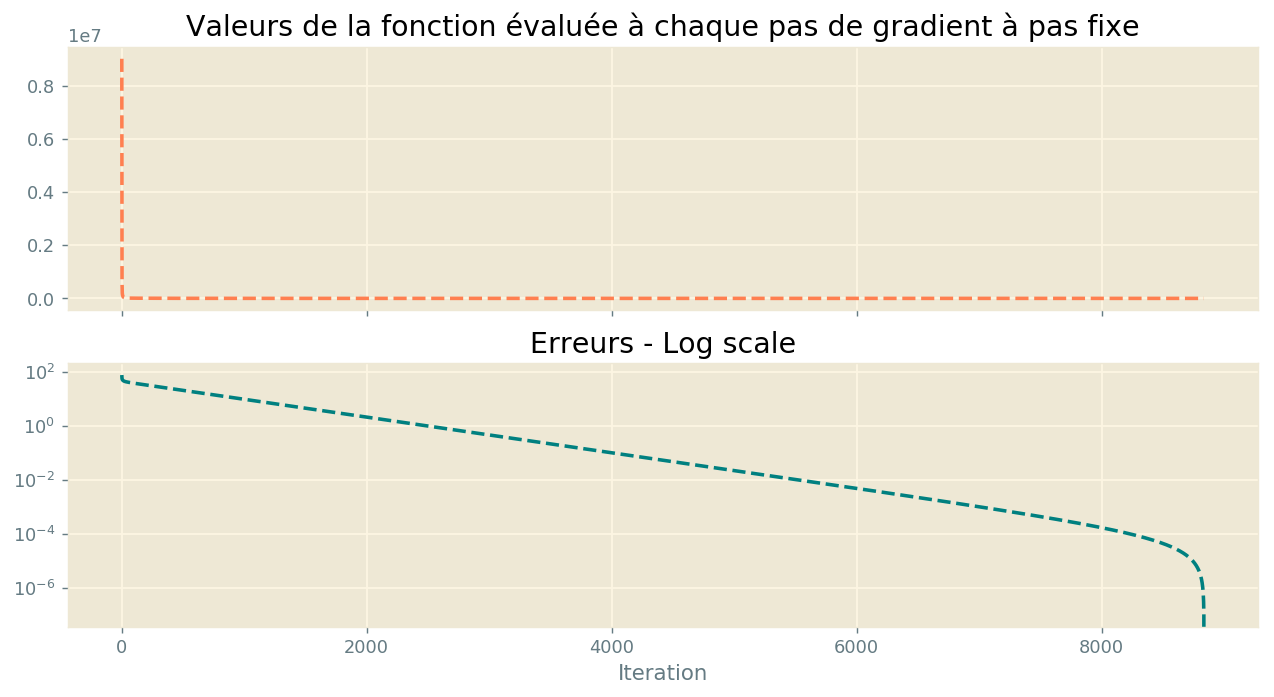

In [438]:
x0 = np.random.normal(10, 9, size = N)
Umin, route, routeX = Gradient_descent_fixed(N, 
            step, x0, J, plot=True, Iterations=10000, epsilon=0.0000001)
print(Umin)

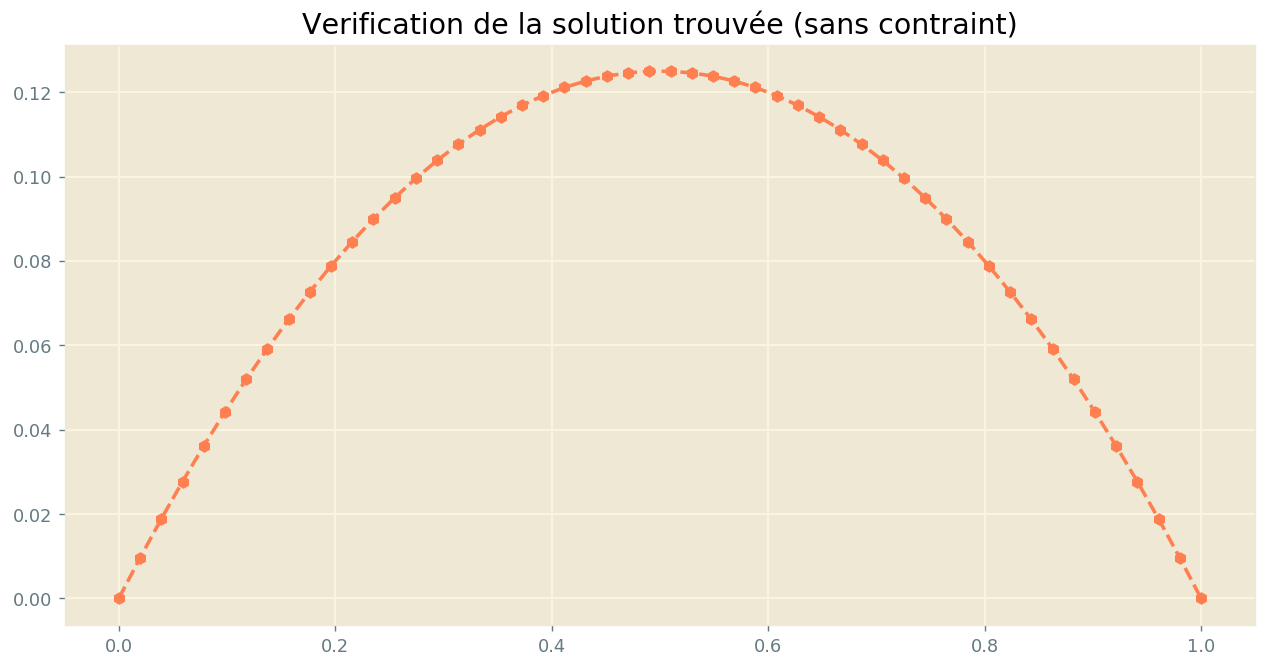

In [439]:
U = np.zeros(N+2)
U[1:-1] = Umin[:]
fig,axs = plt.subplots(figsize = (12, 6), dpi =128, sharex = True)
axs.set_title("Verification de la solution trouvée (sans contraint)")
axs.plot(xx, U, "--h", color = "coral", linewidth = 2);

***Commentaire:*** L'algorithme de la méthode de gradient à pas fixe proposée avant *(TP 1)* est toujours valide et peut être utilisé pour résoudre le problème posé. Elle converge bien vers le résultat souhaité.

### Question 2 -- la méthode du gradient projeté

In [41]:
def Gradient_Proj(N, p, x0, func, epsilon= 0.001, Iterations = 4004, plot = False):
    # initialisation
    x_old = np.random.normal(size = N)
    x_new = x0
    i = 0
    route = [func(x0)]
    routeX = np.array([x0])
    
    # la boucle principal
    while np.linalg.norm(x_old-x_new) > epsilon and i < Iterations:
        x_old = np.copy(x_new)           
        d = -1*gradient(func, x_old)
        x_new = x_old + p*d
        x_new = projection(x_new, g_j[1:-1])
        
        route.append(func(x_new))
        routeX = np.concatenate((routeX, [x_new]))
        i+=1
    
    # plot pour voir la route du gradient
    if plot:
        i+=1
        # on calcule les erreurs sur chaque pas
        errors = np.zeros(i)
        for k in range(i):
            errors[k] = np.linalg.norm(routeX[k] - x_new)      
        
        xx = np.arange(0, i, 1)
        
        fig,axs = plt.subplots(2, 1, figsize = (12, 6), dpi =128, sharex = True)
        axs[0].set_title("Valeurs de la fonction"
                         "évaluée à chaque pas de gradient projeté")
        axs[0].plot(xx, route, "--", color = "coral", linewidth = 2)
        axs[1].set_title("Erreurs - Log scale")
        axs[1].set_yscale("log")
        axs[1].plot(xx, errors, "--", color = "teal", linewidth = 2)
        plt.xlabel("Iteration");
    
    return x_new, route, routeX

[0.0411199  0.08180432 0.12200263 0.16166497 0.20074265 0.23918846
 0.27695709 0.31400545 0.35029299 0.38578201 0.42043797 0.4542297
 0.48712972 0.51911436 0.55016401 0.58026323 0.60940089 0.63757024
 0.66476898 0.69099926 0.7162677  0.74058529 0.76396735 0.7864334
 0.80800701 0.82871561 0.84859033 0.8676657  0.88597942 0.90357209
 0.92048685 0.93676912 0.95246618 0.96762685 0.98230114 0.99653979
 0.93502499 0.87073655 0.80606365 0.74100627 0.67556443 0.60973811
 0.54352732 0.47693206 0.40995232 0.34258811 0.27483943 0.20670628
 0.13818866 0.06928656]


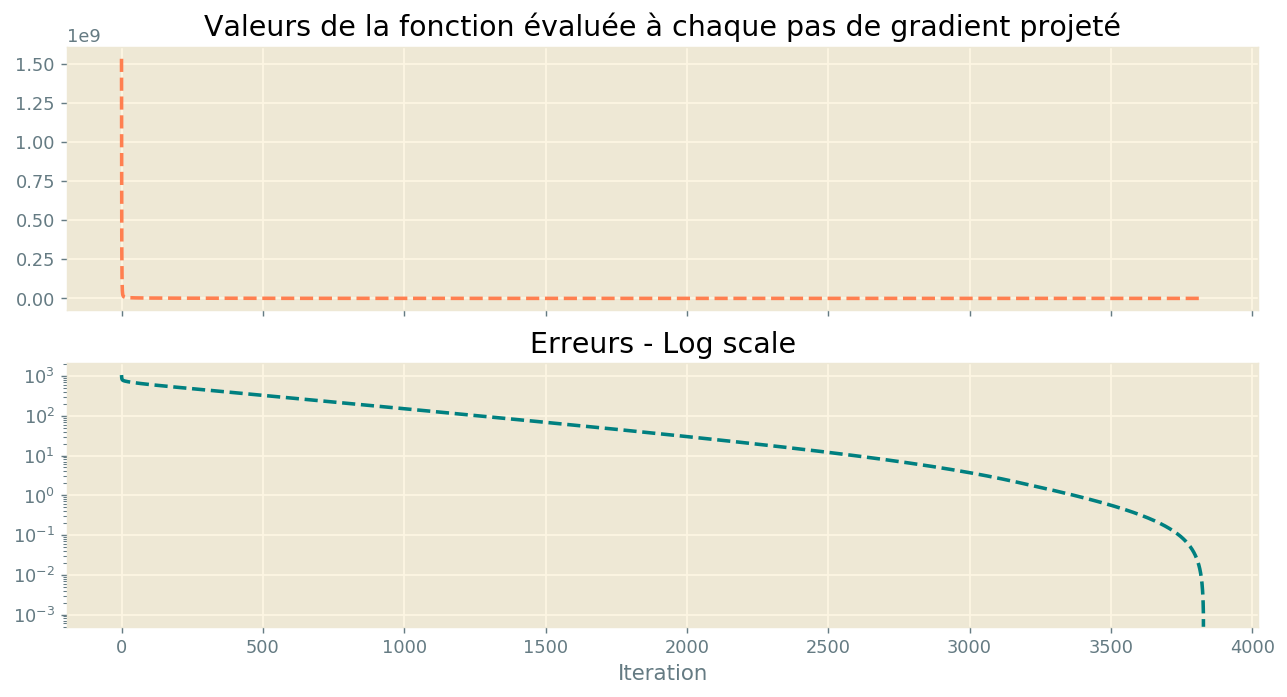

In [441]:
x0 = np.random.normal(111, 99, size = N)
Umin, routeF, routeX = Gradient_Proj(N, step, x0, J, plot=True, Iterations=20000)
print(Umin)

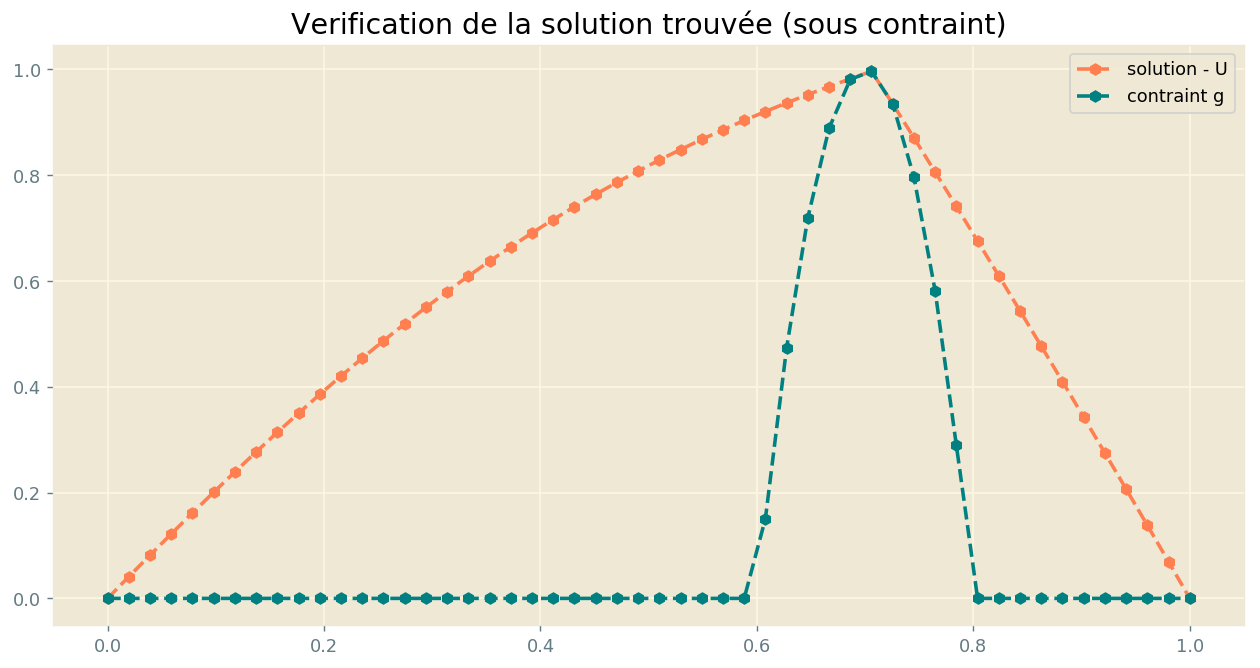

In [240]:
U = np.zeros(N+2)
U[1:-1] = Umin[:]
fig,axs = plt.subplots(figsize = (12, 6), dpi =128, sharex = True)
axs.set_title("Verification de la solution trouvée (sous contraint)")
axs.plot(xx, U, "--h", color = "coral", linewidth = 2, label = "solution - U");
axs.plot(xx, g_j, "--h", color = "teal", linewidth = 2, label = "contraint g");
plt.legend();

### Question 3 -- les tests pour différents valeur de n

Vérification de la condition du2 = -1:  [  0.          -1.04915831  -1.0851447   -1.09831663  -1.08514471
  -1.04915832 -32.31653865  -1.00000001  -1.00000001   0.        ]
Vérification de la condition du2 = -1:  [  0.          -1.08184951  -1.16012199  -1.23139676  -1.29255882
  -1.34093517  -1.37441143  -1.39152441  -1.39152599  -1.37441591
  -1.34094177  -1.29256641  -1.231404    -1.16012766  -1.0818526
 -89.42717482  -1.          -1.00000001  -1.          -1.
  -1.           0.        ]
Vérification de la condition du2 = -1:  [   0.           -1.13258379   -1.2641628    -1.39373982   -1.5203325
   -1.64298103   -1.76075489   -1.8727603    -1.97814656   -2.07611286
   -2.16591383   -2.24686579   -2.31835145   -2.37982501   -2.43081611
   -2.47093367   -2.49986885   -2.51739754   -2.5233822    -2.51777299
   -2.50060836   -2.47201474   -2.43220594   -2.38148127   -2.32022403
   -2.24889753   -2.16804315   -2.07827501   -1.98027589   -1.87479207
   -1.76262738   -1.64463734   -1.52172

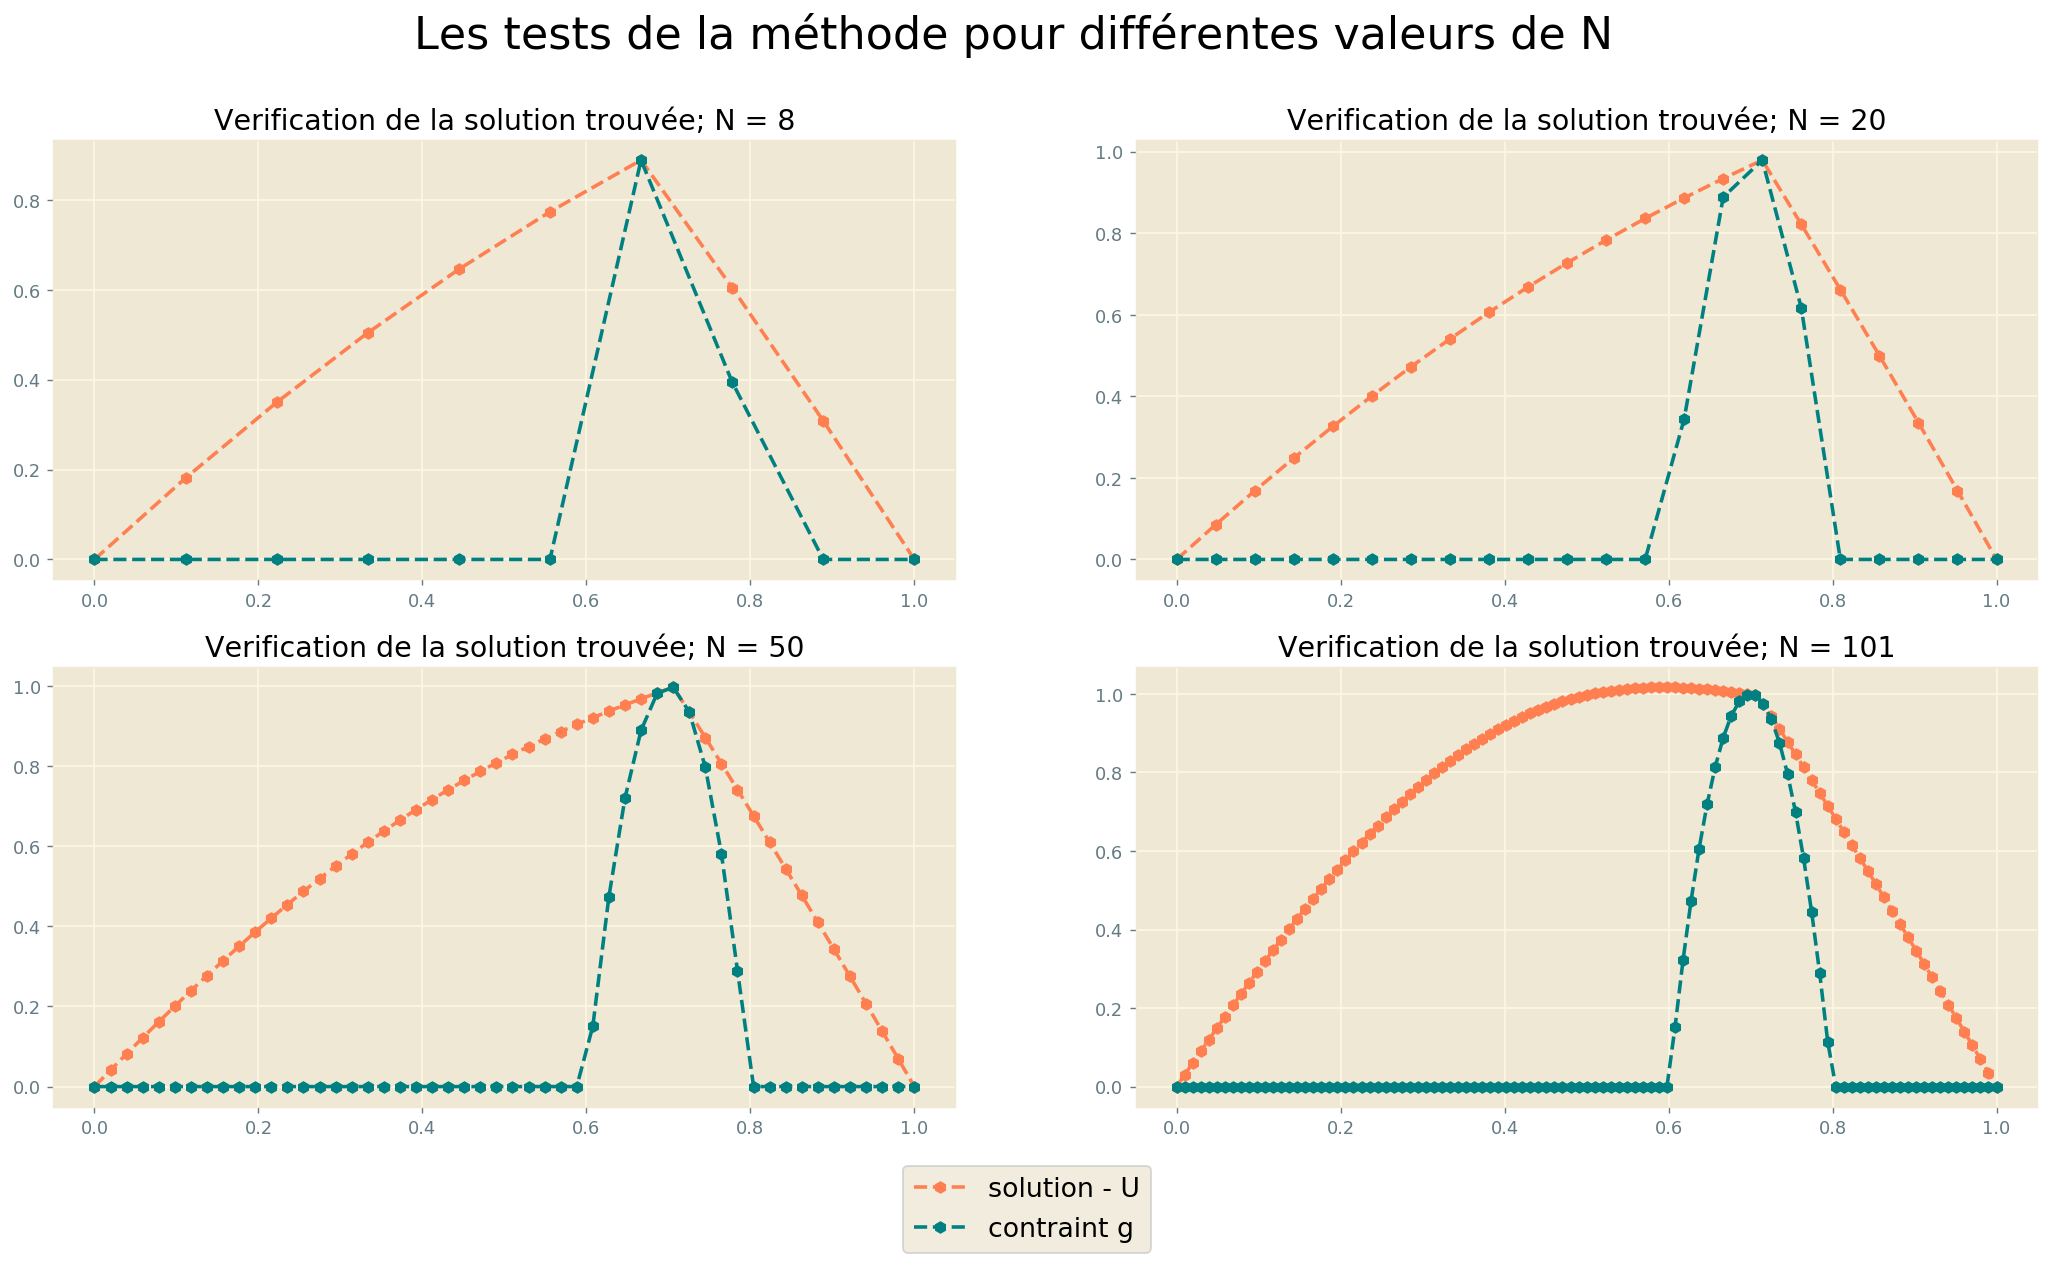

In [247]:
Ns = [8, 20, 50, 101]
fig, axs = plt.subplots(2, 2, figsize = (20, 10), dpi=128)
fig.suptitle("Les tests de la méthode"
             " pour différentes valeurs de N", 
             fontsize = 25, color = "black")

for i in range(len(Ns)):
    N = Ns[i]
    # discretisation
    h = 1/(N+1)
    xx = np.array(np.arange(0, N+2, 1)*h)

    A = matrix_A(N)/(2*h**2)
    b = np.ones(N)
    g_j = g_func(xx)
    
    # fonction à minimiser
    def J(x):
        assert len(x) == len(b), "Wrong dimensions"
        return 1/2*A@x@x - b@x

    # calcul du pas
    eigval, eigvect = np.linalg.eig(A)
    step = 2/(eigval[0] + eigval[-1])

    x0 = np.random.normal(111, 99, size = N)   
    Umin, route, routeX = Gradient_Proj(N, step, x0, J, plot=False, Iterations=20000)

    U = np.zeros(N+2)
    U[1:-1] = Umin[:]
    
    # l'approxiamtion de f'' - vect
    def du2vect(U):
        N = len(U)
        du2 = np.zeros(N)
        for i in range(1, N-1):
            du2[i] = (U[i+1] - 2*U[i] + U[i-1])/(h**2)
        return du2
    print("Vérification de la condition du2 = -1: ", du2vect(U))

    axs[i//2][i%2].set_title("Verification de la solution trouvée; N = {:d}".format(N))
    axs[i//2][i%2].plot(xx, U, "--h", color = "coral", 
                        linewidth = 2, label = "solution - U");
    axs[i//2][i%2].plot(xx, g_j, "--h", color = "teal", 
                        linewidth = 2, label = "contraint g");
    
handles, labels = axs[-1, -1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize = 15);

***Commentaire:*** On voit bien, que le programme marche pour les valeurs différentes de N. De plus, on remarque que $-u'' \approx 1$ pour les valeurs de la fonction ou $u(x) \neq g(x)$. On peut, également noter que le calcul de $u''$ est l'operation lourde et donc elle ralentit considérablement l'exécution du programme.

- - -
- - -

## Exercice 2
#### *(mise en oeuvre d'une méthode de pénalisation)*

In [42]:
def J(X):
    return 2*X[0]**2 + 3*X[0]*X[1] + 2*X[1]**2  

### Question 1
On suit même stratégie comme en TP 2:
Pour trouver les points critiques on veut résoudre le système suivant:
$$
\begin{cases}
\frac {\partial J}{\partial x} = 4x + 3y = 0 & (1)\\
\frac {\partial J}{\partial y} = 4y + 3x = 0 & (2) 
\end{cases}
$$
D'où on trouve que $x=y=0$. Vérifions-le en utilisant la méthode de gradient à pas optimal.

Le minimum est trouvé à (0.0, 0.0)


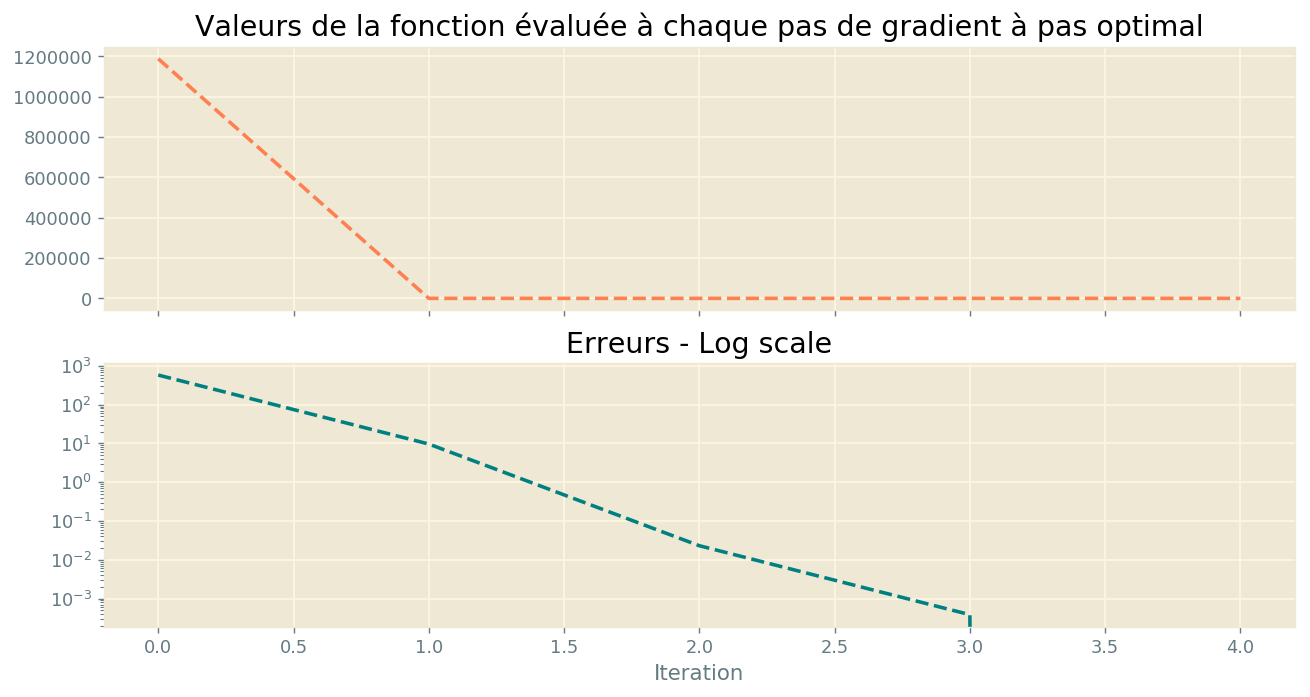

In [43]:
Pmin, routeF, routeXopt = Gradient_descent_optimal(2, [404, 420], J, plot=True)
print("Le minimum"
      " est trouvé à ({:.1f}, {:.1f})".format(routeXopt[-1,0], routeXopt[-1,1]))

### Question 2 -- Méthode du gradient projeté

In [433]:
# fonction auxiliaire pour décrire Q
def projection(X):
    return np.minimum(-0.5, X)

***Commentaire:*** Malheureusement, nous devrons modifier un peu notre implementation de gradient projeté précédente pour être cohérent avec notre nouveau domaine Q; Cependant, maintenant, elle est plus ou moins généralisé.

In [434]:
def Gradient_Proj_2(N, p, x0, func, 
                    projection, epsilon= 0.001, Iterations = 4004, plot = False):
    # initialisation
    x_old = np.random.normal(size = N)
    x_new = x0
    i = 0
    route = [func(x0)]
    routeX = np.array([x0])
    
    # la boucle principal
    while np.linalg.norm(x_old-x_new) > epsilon and i < Iterations:
        x_old = np.copy(x_new)           
        d = -1*gradient(func, x_old)
        x_new = x_old + p*d
        x_new = projection(x_new)
        
        route.append(func(x_new))
        routeX = np.concatenate((routeX, [x_new]))
        i+=1
    
    # plot pour voir la route du gradient
    if plot:
        i+=1
        # on calcule les erreurs sur chaque pas
        errors = np.zeros(i)
        for k in range(i):
            errors[k] = np.linalg.norm(routeX[k] - x_new)      
        
        xx = np.arange(0, i, 1)
        
        fig,axs = plt.subplots(2, 1, figsize = (12, 6), dpi =128, sharex = True)
        axs[0].set_title("Valeurs de la fonction"
                         " évaluée à chaque pas de gradient projeté")
        axs[0].plot(xx, route, "--", color = "coral", linewidth = 2)
        axs[1].set_title("Erreurs - Log scale")
        axs[1].set_yscale("log")
        axs[1].plot(xx, errors, "--", color = "teal", linewidth = 2)
        plt.xlabel("Iteration");
    
    return x_new, route, routeX

Point de minimisation:  [-0.5 -0.5]
Itérations:  73


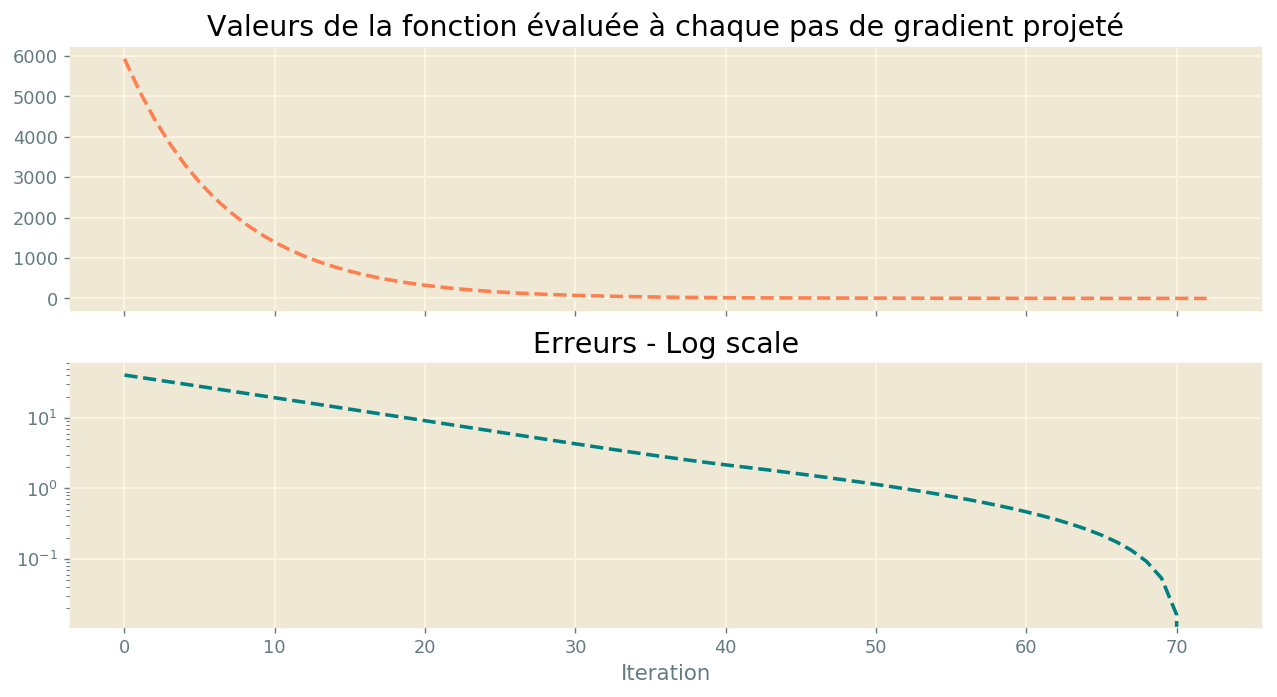

In [435]:
N = 2
step = 0.01
np.random.seed(42)
x0 = np.random.normal(-30, 5, size = N)

Umin, route, routeX = Gradient_Proj_2(N, step, 
                x0, J, projection, plot=True, Iterations=20000)
print("Point de minimisation: ", Umin)
print("Itérations: ", len(routeX))

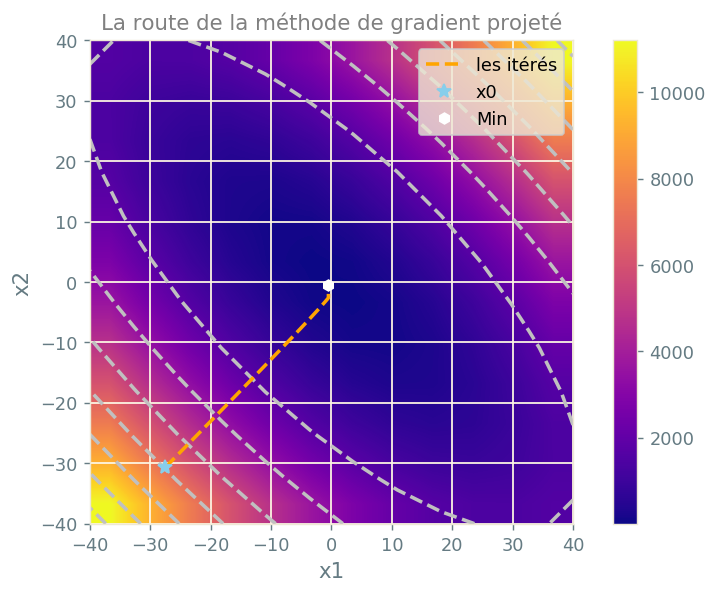

In [257]:
# On applique la même technique qu'avant

fig, axs = plt.subplots(figsize = (8,5), dpi = 128)
ContourPlusGradient(J, axs=axs, grad = False, argmin = -40, argmax = 40)
plt.title("La route de la méthode"
          " de gradient projeté", fontsize = 12, color = "gray")

axs.plot(routeX[:,0], routeX[:,1], "--", color = "orange", 
         linewidth = 2, label = "les itérés");
axs.plot(x0[0], x0[1], "*", color = "skyblue", 
         linewidth = 2, markersize = 8, label = "x0");
axs.plot(Umin[0], Umin[1], "h", color = "white", 
         linewidth = 2, markersize = 6, label = "Min");
plt.legend();

***Commentaire:*** On remarque que la méthode converge exactement vers le point de minimisation. Elle a eu besoin de 73 itérations.

### Question 3 -- Méthode de pénalisation

In [323]:
def penalty(X):
    return J(X) + 1/eps*(np.sum(np.maximum(np.array(X)+0.5,0)))**2

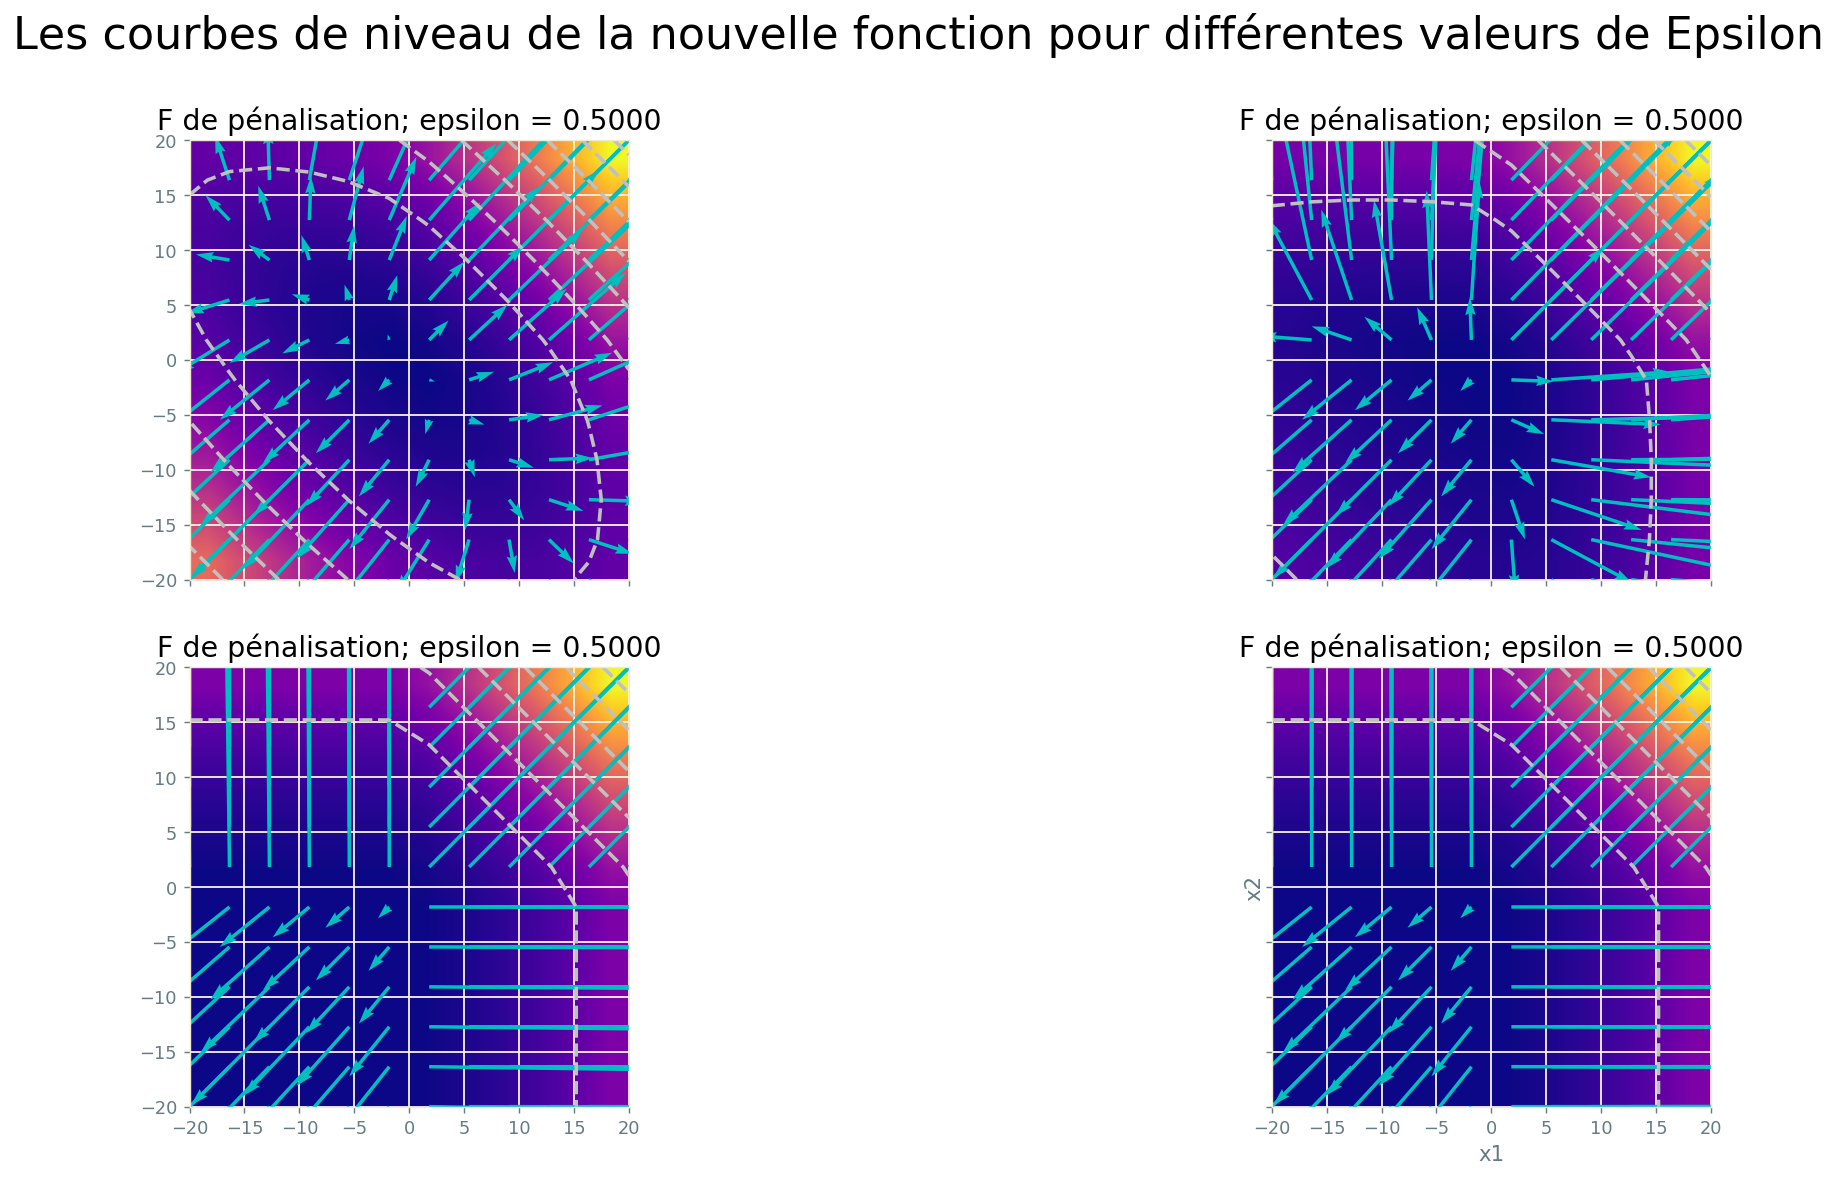

In [325]:
epsilons = [1, 0.1, 0.001, 1e-4]

fig, axs = plt.subplots(2, 2, figsize = (20, 10), dpi=128, 
                        sharex = True, sharey = True)
fig.suptitle("Les courbes de niveau de la nouvelle fonction"
             " pour différentes valeurs de Epsilon", 
             fontsize = 25, color = "black")

for i in range(len(epsilons)):
    eps = epsilons[i]
    axs[i//2][i%2].set_title("F de pénalisation; epsilon = {:.4f}".format(epsilon))
    ContourPlusGradient(penalty, axs=axs[i//2][i%2], 
                        grad = True, argmin = -20, argmax = 20, colorbar = False)
    

Point de minimisation - pas fixe:  [-0.49924841 -0.4989437 ]
Itérations - pas fixe:  329
Itérations - pas optimal:  5
Point de minimisation - pas optimal:  [-0.49804773 -0.5       ]


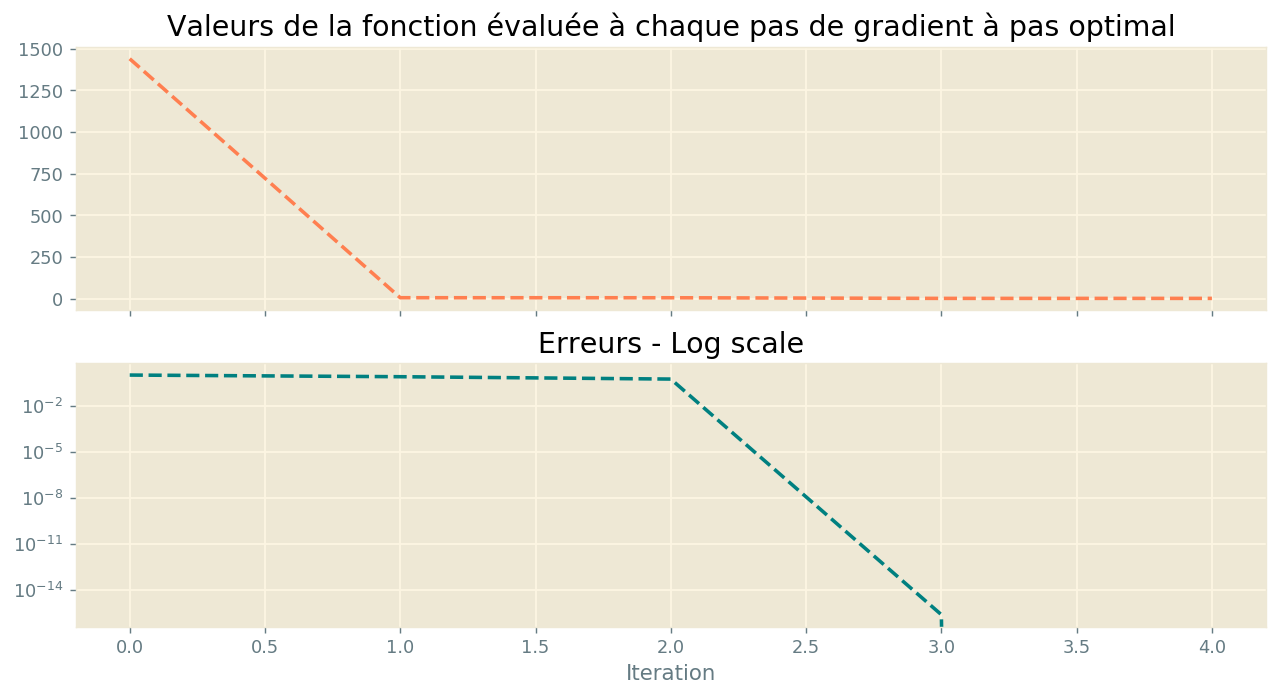

In [326]:
eps = 10e-4
x0 = [-0.3, 0.5]
N = 2

Pmin, routeF, routeXfix = Gradient_descent_fixed(N, 0.001, x0, penalty, plot=False)
print("Point de minimisation - pas fixe: ", Pmin)
Pmin, routeF, routeXopt = Gradient_descent_optimal(N, x0, penalty, plot=True)
print("Itérations - pas fixe: ", len(routeXfix))
print("Itérations - pas optimal: ", len(routeXopt))
print("Point de minimisation - pas optimal: ", Pmin)

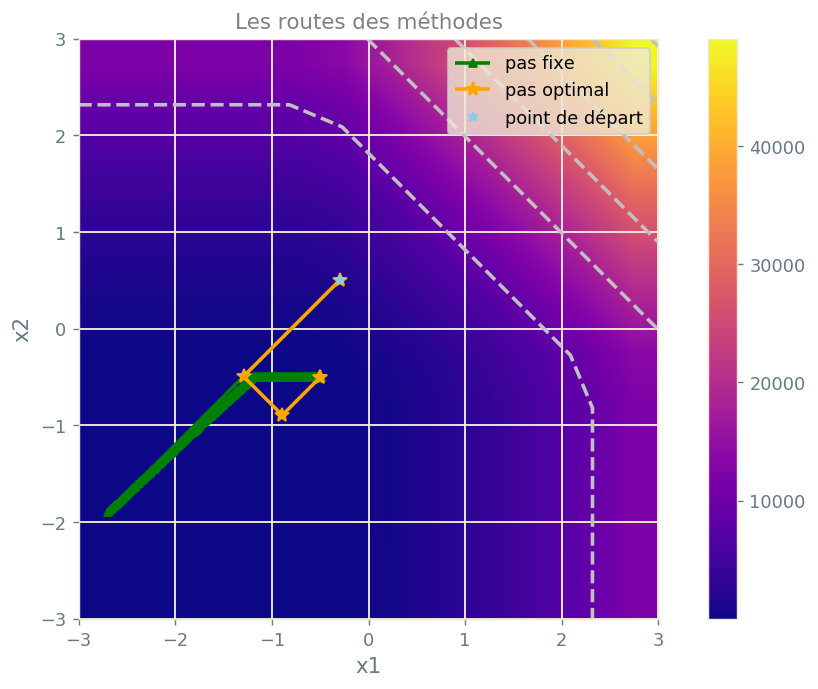

In [327]:
fig, axs = plt.subplots(figsize = (10,6), dpi = 128)
ContourPlusGradient(penalty, axs=axs, grad = False, argmin = -3, argmax = 3)
plt.title("Les routes des méthodes", fontsize = 12, color = "gray")
axs.plot(routeXfix[:,0], routeXfix[:,1], "-^", color = "green", 
         linewidth = 2, markersize = 5, label = "pas fixe");
axs.plot(routeXopt[:,0], routeXopt[:,1], "-*", color = "orange", 
         linewidth = 2, markersize = 8, label = "pas optimal");
axs.plot(x0[0], x0[1], "*", color = "skyblue", 
         linewidth = 2, markersize = 6, label = "point de départ");
plt.legend();

***Commentaire:*** On peut définitivement dire que la vitesse de convergence est satisfaisante dans les deux cas. On a vu qu'il fallait 329 itérations pour converger pour le gradient à pas fixe et 5 itérations pour le gradient à pas optimal.

Point de minimisation - pas fixe:  [-0.49972384  0.05092517]
Itérations - pas fixe:  190
Itérations - pas optimal:  8
Point de minimisation - pas optimal:  [-0.26699767 -0.26633886]


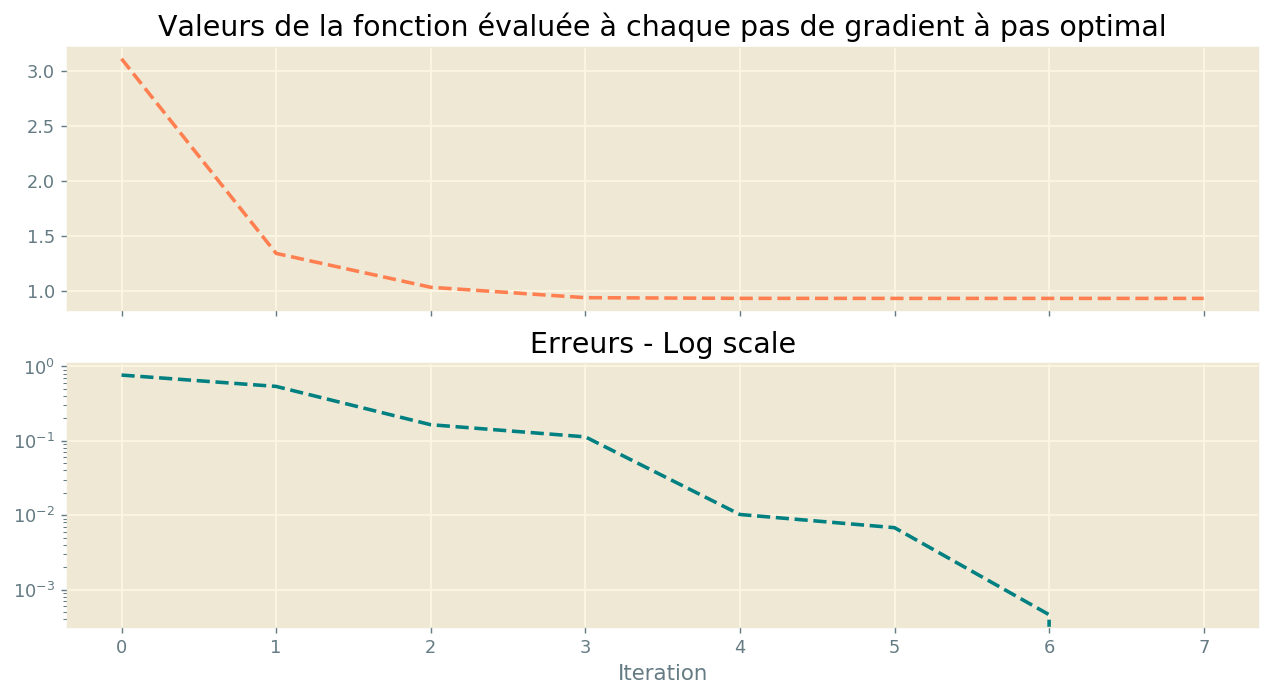

In [328]:
eps = 0.5
x0 = [-0.3, 0.5]
N = 2

Pmin, routeF, routeXfix = Gradient_descent_fixed(N, 0.001, x0, penalty, plot=False)
print("Point de minimisation - pas fixe: ", Pmin)
Pmin, routeF, routeXopt = Gradient_descent_optimal(N, x0, penalty, plot=True,)
print("Itérations - pas fixe: ", len(routeXfix))
print("Itérations - pas optimal: ", len(routeXopt))
print("Point de minimisation - pas optimal: ", Pmin)

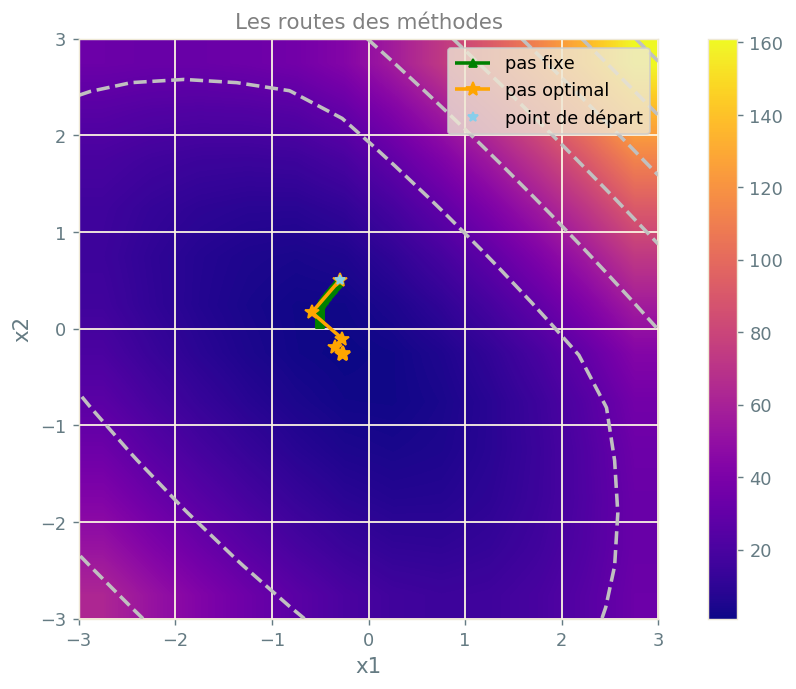

In [322]:
fig, axs = plt.subplots(figsize = (10,6), dpi = 128)
ContourPlusGradient(penalty, axs=axs, grad = False, argmin = -3, argmax = 3)
plt.title("Les routes des méthodes", fontsize = 12, color = "gray")
axs.plot(routeXfix[:,0], routeXfix[:,1], "-^", color = "green", 
         linewidth = 2, markersize = 5, label = "pas fixe");
axs.plot(routeXopt[:,0], routeXopt[:,1], "-*", color = "orange", 
         linewidth = 2, markersize = 8, label = "pas optimal");
axs.plot(x0[0], x0[1], "*", color = "skyblue", 
         linewidth = 2, markersize = 6, label = "point de départ");
plt.legend();

***Commentaire:*** On voit qu'avec une pénalisation faible, - $\varepsilon = 0.5$ - les méthodes ne convergent pas vers la solution exacte. Les solutions trouvées sont assez proches, mais le terme de pénalisation n’est pas suffisamment significatif, alors, on minimise la fonction initiale J, en quelque sorte. Donc, on ne peut pas observer la propre convergence.

In [334]:
N = 2
step = 0.01
np.random.seed(42)
x0 = [-0.3, 0.5]

Umin, route, routeX = Gradient_Proj_2(N, step, 
                        x0, J, projection, plot=False, Iterations=20000)
print("Point de minimisation: ", Umin)
print("Itérations: ", len(routeX))

Point de minimisation:  [-0.5 -0.5]
Itérations:  3


***Commentaire:*** Comme on a vu avant, gradient à pas optimal converge plus rapidement que gradient à pas fixe, ce qui est attendu. De plus, on a vu que gradient projeté converge aussi vite. On peut même dire qu'elle est plus efficace (3 itérations vs 5 du gradient à pas optimal), cependant, la méthode de pénalisation avec gradient à pas optimal a un avantage très utile: elle ne fait pas de calcul de la projection, que peut devenir une operation assez lourde avec les fonctions plus compliquées et domaines fastidieux. 


***Conclusion:*** Pour conclure, on peut dire qu’ayant une fonction particulière à minimiser sous des contraintes données il faut être soigneux en choix de la méthode. Il existe des cas où le gradient projeté est la plus efficace, de la même manière il est parfois plus raisonnable d’utiliser gradient à pas optimal avec une valeur d'epsilon bien équilibrée.

# TP 4

## Exercice 1
#### *(méthode d'Uzawa)*

### Question 1 -- L'ensemble des contraintes

On veut mettre l'ensemble des contraintes sous la forme $\mathbf K = \{x \in \mathbb R^{n} : Cx = f\}$. Pour ça on construit la matrice *C* de sorte que:
$$
    Cx = f \iff \begin{pmatrix} 
    \langle x, u \rangle    \\
    \langle x, e \rangle
    \end{pmatrix} = \begin{pmatrix} 
    1   \\
    r0
    \end{pmatrix}
$$
Alors, on peut definir C comme suivant:
$$
    C = \begin{pmatrix} 
    u    \\
    e
    \end{pmatrix}
$$
où ***u*** et ***e*** sont des vecteurs de la taille ***n***, donc ***C*** est de la taille $(2, n)$.

### Question 2 -- L'initialisation

In [11]:
r0 = 2.5
n = 5
e = np.linspace(1, n, n)

A = np.diag(e)
R = np.random.rand(n, n)
A = A + 0.5*np.dot(np.transpose(R),R)
print("Matrice A:\n", A)

Matrice A:
 [[1.86545699 0.55713432 0.57753897 0.70576089 1.02013369]
 [0.55713432 3.19560673 0.70412788 0.46111872 1.20530244]
 [0.57753897 0.70412788 3.8538965  0.48025208 1.0213251 ]
 [0.70576089 0.46111872 0.48025208 4.58469629 0.84210096]
 [1.02013369 1.20530244 1.0213251  0.84210096 6.61508482]]


***Réponse:*** Nous construisons la matrice A de la taille $(n, n)$, de manière qu'elle ressemble à la matrice de covariance. Tout d'abord, on veut qu'elle soit symétrique. Il est garanti à la dernière ligne du programme où une matrice aléatoire $\langle R^{T}, R \rangle$ est ajoutée à la matrice A, qui n'a été initialisée qu'avec des éléments diagonaux.

In [576]:
def J(x):
    return 1/2*x@A@x

u = np.ones(n)

def H(x):
    H = np.empty(2)
    H[0] = np.dot(x, u) - 1
    H[1] = np.dot(x, e) - r0
    return H

# lambdas est defini dehors de fonction
lambs = np.array([4, 2])

In [577]:
x = np.zeros(n)
L(x)

-9.0

In [578]:
def Uzawa(A, J, H, x0, Minimiser, epsilon = 0.00001, Iterations = 4004, plot = False):
    # initialisation
    lambs = np.array([1, 1])
    N = len(x0)
    # on adapt ro à N
    ro = 1/10**(N//10 + 1)
    i = 0
    x_old = np.random.normal(size = N)
    x_new = x0
    
    # on definit Lagrangien comme ci-dessous, 
    # pour qu'on puisse le passer aux autres fonction comme fonction à minimiser 
    def L(x):
        return J(x) + H(x)@lambs
    
    # pour plot
    route = [L(x0)]
    routeX = np.array([x0])
    
    # la boucle principal
    while i < Iterations and np.linalg.norm(x_new-x_old) > epsilon:
        x_old = np.copy(x_new)
        if Minimiser == Gradient_descent_fixed:
            x_new, whatever, nomatter = Minimiser(N=N,p=0.1, 
                                        func=L, x0=x_old, plot=False)
        else:
            x_new, whatever, nomatter = Minimiser(N=N, 
                                        func=L, x0=x_old, plot=False)
        
        lambs = lambs + ro*H(x_new)
        
        route.append(L(x_new))
        routeX = np.concatenate((routeX, [x_new]))
        #print("Lambda {:d} is ({:.2f},{:.2f}".format(i, lambs[0], lambs[1]))
    
        i+=1
        
    # plot pour voir la route de la méthode
    if plot:
        i+=1
        # on calcule les erreurs sur chaque pas
        errors = np.zeros(i)
        for k in range(i):
            errors[k] = np.linalg.norm(routeX[k] - x_new)      
        
        xx = np.arange(0, i, 1)
        
        fig,axs = plt.subplots(2, 1, figsize = (12, 6), dpi =128, sharex = True)
        axs[0].set_title("Valeurs de la fonction évaluée à chaque pas d'Uzawa")
        axs[0].plot(xx, route, "--", color = "coral", linewidth = 2)
        axs[1].set_title("Erreurs - Log scale")
        axs[1].set_yscale("log")
        axs[1].plot(xx, errors, "--", color = "teal", linewidth = 2)
        plt.xlabel("Iteration");
        
    return x_new, route, routeX 

x0:
 [0.41564849 0.00699123 0.15289118 0.00426948 0.42019962]
x0 sum check:
 1.0
Xmin:
 [0.36182808 0.23815431 0.0879085  0.16166341 0.15030965]
Xmin sum check:
 0.9998639423513821


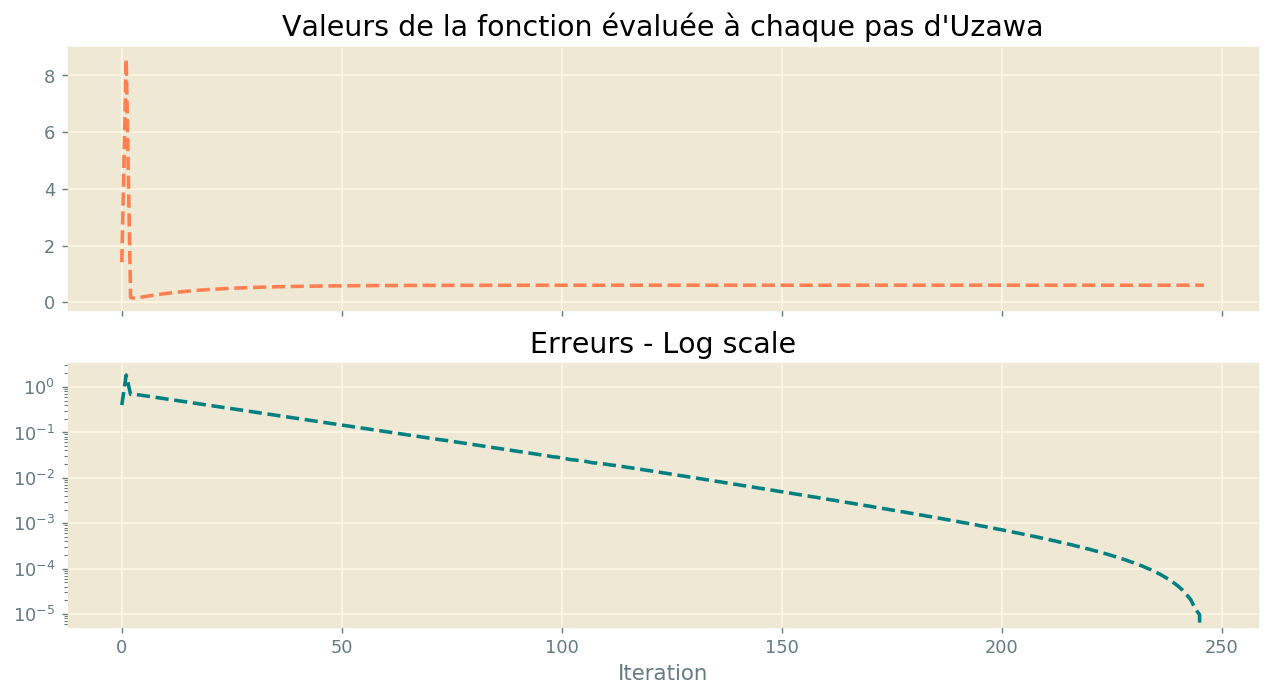

In [557]:
# avec gradient à pas optimal; n = 5
x0 = np.random.random(size=n)
x0 /= np.sum(x0)
np.random.seed(42)
print("x0:\n", x0)
print("x0 sum check:\n", np.sum(x0))
Xmin, routeF, routeX = Uzawa(A, J, H, x0, Gradient_descent_optimal, plot=True)
print("Xmin:\n", Xmin)
print("Xmin sum check:\n", np.sum(Xmin))

x0:
 [0.14476553 0.24260512 0.2340985  0.33512337 0.04340748]
x0 sum check:
 0.9999999999999999
Xmin:
 [0.36176434 0.23814498 0.08791922 0.16166782 0.1503125 ]
Xmin sum check:
 0.9998088606935341


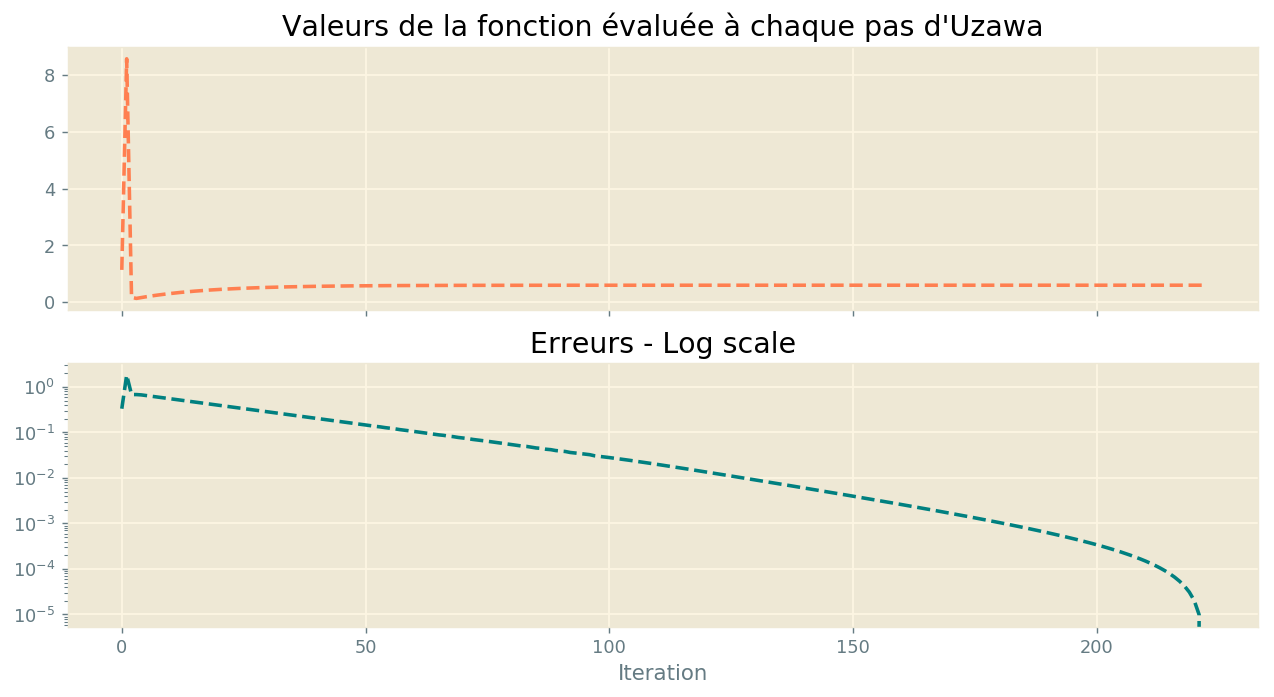

In [558]:
# avec gradient à pas fixe; n = 5
x0 = np.random.random(size=n)
x0 /= np.sum(x0)
np.random.seed(81)
print("x0:\n", x0)
print("x0 sum check:\n", np.sum(x0))
Xmin, routeF, routeX = Uzawa(A, J, H, x0, Gradient_descent_fixed, plot=True)
print("Xmin:\n", Xmin)
print("Xmin sum check:\n", np.sum(Xmin))

x0:
 [0.18532346 0.19700581 0.07312334 0.11046224 0.16622674 0.12555831
 0.07546756 0.04788157 0.01689598 0.00205499]
x0 sum check:
 1.0000000000000002
Xmin:
 [ 0.37551613  0.22637151  0.12329258  0.12959466  0.0687053   0.04772775
  0.03695576 -0.03220278  0.02326257 -0.00563277]
Xmin sum check:
 0.9935906975851736
CPU times: user 5.46 s, sys: 71.2 ms, total: 5.54 s
Wall time: 5.51 s


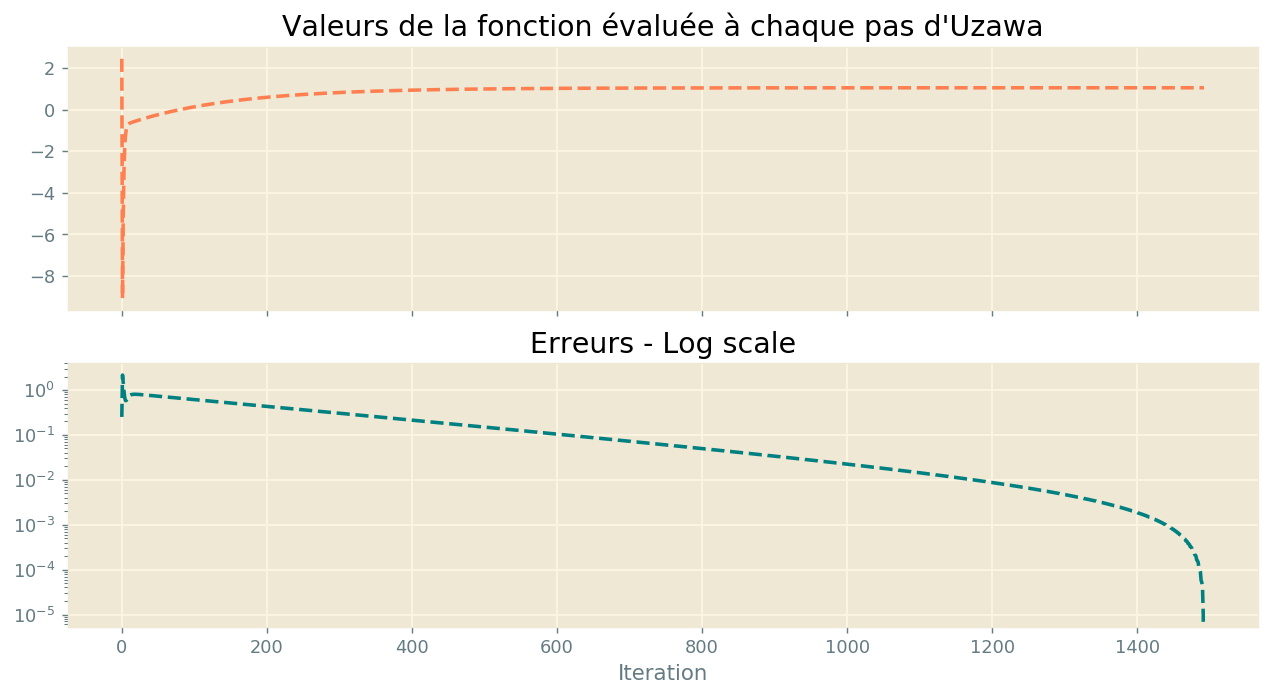

In [563]:
%%time
# avec gradient à pas optimal
# pour n = 10
x0 = np.random.random(size=n)
x0 /= np.sum(x0)
np.random.seed(404)
print("x0:\n", x0)
print("x0 sum check:\n", np.sum(x0))
Xmin, routeF, routeX = Uzawa(A, J, H, x0, Gradient_descent_optimal, plot=True)
print("Xmin:\n", Xmin)
print("Xmin sum check:\n", np.sum(Xmin))

x0:
 [0.01627728 0.04577791 0.05534888 0.01564696 0.0190147  0.06489023
 0.04321231 0.07325098 0.00023706 0.04255731 0.02080948 0.00170876
 0.06875938 0.01754838 0.06012898 0.05446695 0.00260764 0.05201693
 0.00732753 0.01332193 0.06425272 0.04499188 0.06074364 0.06213465
 0.0242588  0.029403   0.03930572]
x0 sum check:
 0.9999999999999999
Xmin:
 [ 0.14789622  0.41080666  0.13046858  0.13094921  0.05653542  0.00434689
 -0.05997662  0.06984407  0.02520598  0.03159291  0.02241532 -0.00855664
  0.01465012 -0.02144028 -0.02681812  0.00781971  0.00532714  0.03392249
  0.03765402 -0.01551252 -0.013069    0.01023538  0.0023473  -0.00736254
 -0.0096891  -0.00980726 -0.02105076]
Xmin sum check:
 0.948734574201994
CPU times: user 35.3 s, sys: 1.08 s, total: 36.3 s
Wall time: 35.7 s


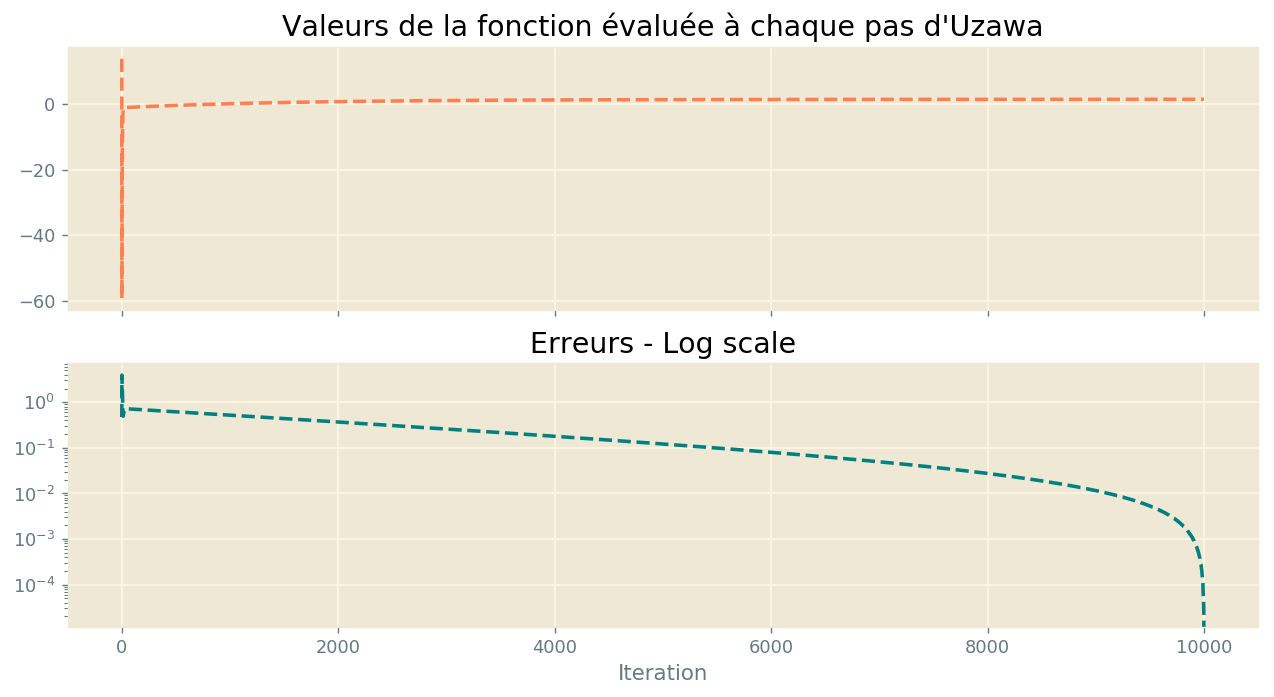

In [579]:
%%time
# avec gradient à pas optimal
# pour n = 27
x0 = np.random.random(size=n)
x0 /= np.sum(x0)
np.random.seed(808)
print("x0:\n", x0)
print("x0 sum check:\n", np.sum(x0))
Xmin, routeF, routeX = Uzawa(A, J, H, x0, 
        Gradient_descent_optimal, plot=True, Iterations=10000,epsilon=1e-8)
print("Xmin:\n", Xmin)
print("Xmin sum check:\n", np.sum(Xmin))

***Commentaire:*** L'inconvénient majeur est *'scalability'* d'algorithm. Pour plus grandes valeurs de N, l'algorithm a besoin de changement en ***ro***: plus le ***N*** est grand, plus le ***ro*** doit être petit. J'ai essayé d'adapter l'algorithm a cet inconvénient, mais le lien entre valeur de ***N*** et valeur de ***ro*** n'est pas tellement clair, alors pour les valeurs plsu grandes (ex. $n=27$) il existe toujours le problème de convergence - si on vérifie la somme de valeurs obtenues, on voit qu'elle n'est pas assez proche à 1, malgré le fait que $||X_{k+1} - X_{k}||<\varepsilon$.

Cependant, on remarque, que pour les valeurs de ***N*** plus petites l'algorithm est stable et efficace.

- - - 
- - -

## Exercice 2
#### *(méthode du recuit simulé)*

### Question 1 -- Les graphiques de fonctions

In [5]:
import random
# les fonctions à minimiser
omegas = [2, 4, 6, 8, 10]
def J1(x):
    return 3 - x*np.sin(omega*np.pi*x)
    
def J2(x):
    return 10*np.sin(0.3*x*np.sin(1.3*x**2 + 0.00001*x**4 + 0.2*x + 80))   

In [6]:
def plotJ(J, a, b, title, ax=None):
    xx = np.linspace(a, b, (b-a)*100)

    if ax == None:
        fig,ax = plt.subplots(figsize = (12, 6), dpi =128)
    ax.set_title(title)
    ax.plot(xx, J(xx), "--", color = "coral", linewidth = 2)
    ax.set_xlabel("x de {:d} à {:d}".format(a,b));

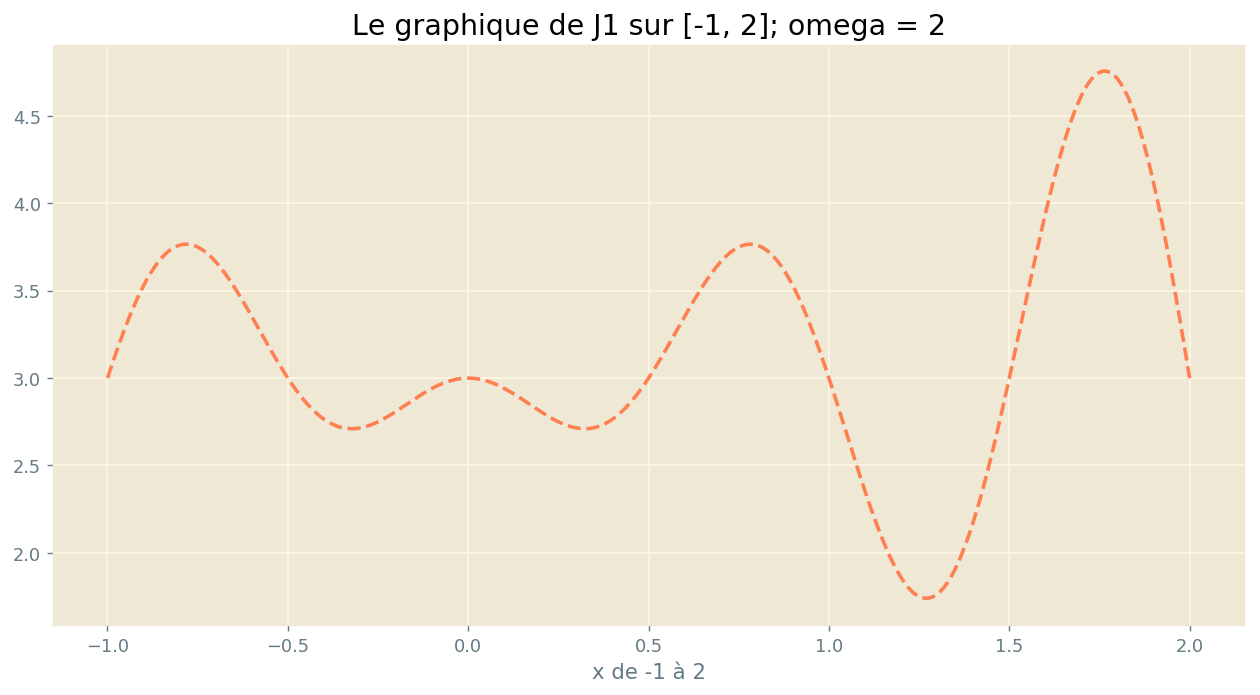

In [7]:
omega = omegas[0]
plotJ(J1, -1, 2, "Le graphique de J1 sur [-1, 2]; omega = {:d}".format(omega))

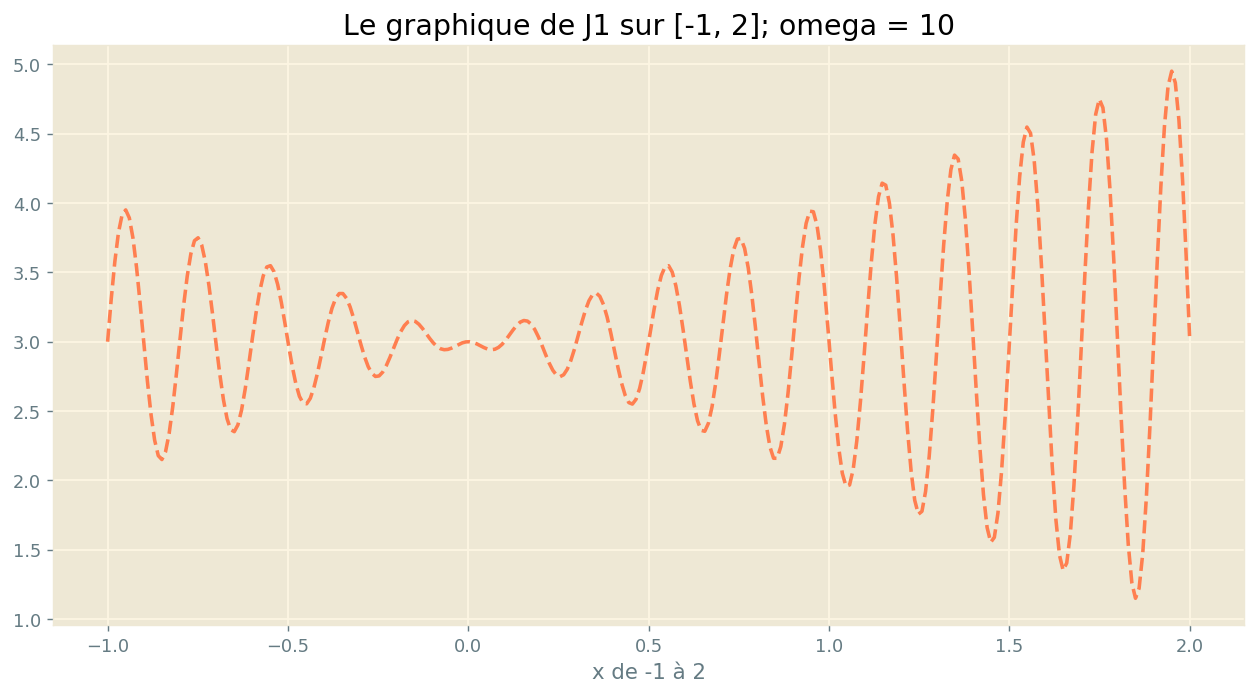

In [587]:
omega = omegas[-1]
plotJ(J1, -1, 2, "Le graphique de J1 sur [-1, 2]; omega = {:d}".format(omega))

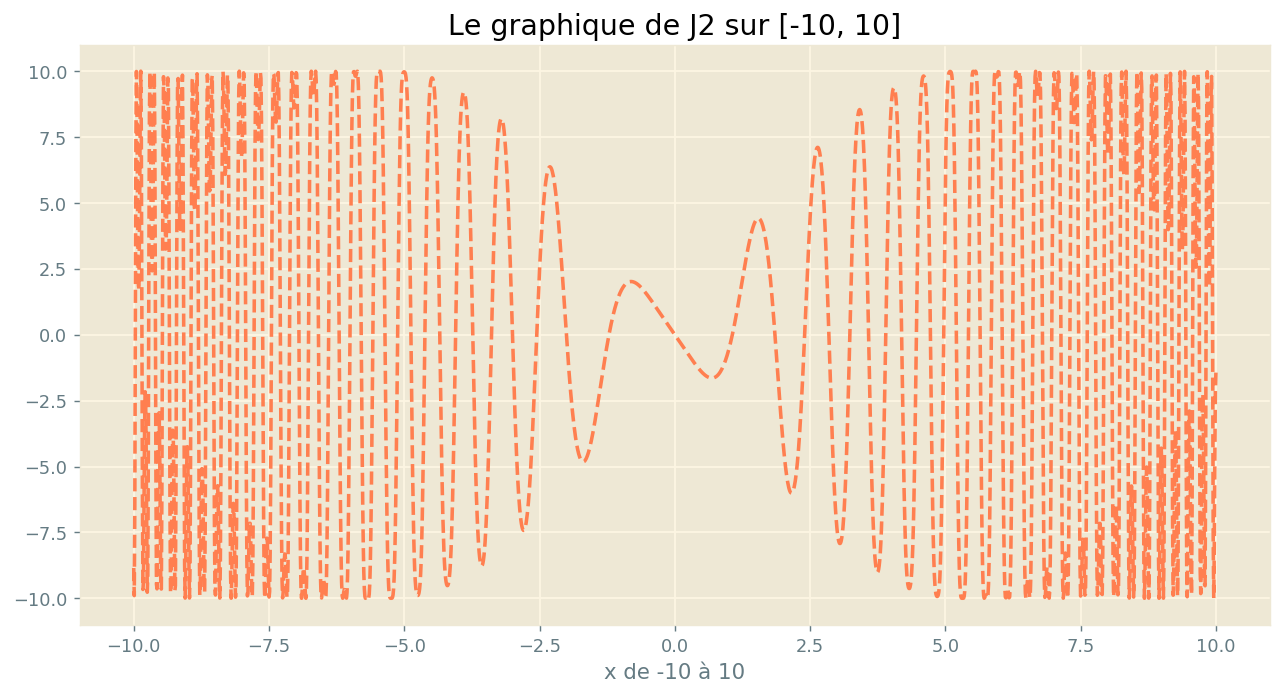

In [588]:
plotJ(J2, -10, 10, "Le graphique de J2 sur [-10, 10]")

***Remarque:*** On remarque nature oscillante des fonctions ci-dessus. Il est clair que les algorithmes de gradient étudiés ci-dessus ne parviendraient qu'à trouver un minimum local, ce qui n'est pas très utile dans le cas de telles fonctions.

- - -

### Question 2 -- Méthode du recuit simulé

In [8]:
#------ fonction signe -------#
def sign(x):
    if (x<0):
        y=-1
    else:
        y=1
    return y

#------ recuit simule -------#
def recuit(x1,x2,J, T0 = 1e8, alpha = 2):
# J: fonction a minimiser sur l intervalle [xl;x2]
# T0: temperature initiale
# alpha: ordre de la loi de refroidissement
# (N,K): donnees du refroidissement
# b: longueur de deplacement
# x: minimum global approche
    K=40000
    N=2000

    b=1e-4

    x=(x2-x1)*random.random()+x1
    print("Point de départ: ", x)
    Tk=T0
    best_pt=x
    Jx=J(x)
    bestvalue=Jx
    
    route = [Jx]
    routeX = [x]

    for k in range(N):
        # formule du refroidissement

        #----------- A COMPLETER -------------#
        Tk = T0*(1-k/N)**alpha

        for l in range(int(max(1,K/N))):
        # Deplacement
            if (x==best_pt):
                xbis=(x2-x1)*random.random()+x1
                #xbis=max(x1,x-np.random.normal(0,0.1)*b)
            # si x est le meilleur point: il faut en prendre
            # un autre aleatoirement qui se trouve a sa gauche mais
            # plus grand que x1 en partant de x comme origine
            else:
            # sinon on se deplace a sa gauche en partant de x de facon
            # aleatoire en partant de x et en pointant vers le meilleur
            # point, avec une longueur aleatoire rand * b, b fixe
                p=random.random()
                if (p<2/3):
                    xbis=max(x1,min(x2,x-sign(x-best_pt)*b*random.random()))
                else:
                    xbis=max(x1,min(x2,x+sign(x-best_pt)*b*random.random()))
        
            # on teste ce nouveau point
            Jxbis = J(xbis)

            deltaJ = Jxbis - J(x)

            # si xbis est meilleur que x, on le prend
            if (deltaJ<0):
                x = xbis

                # et en plus on regarde si on a la meilleure valeur
                if (Jxbis<bestvalue):
                    best_pt=xbis
                    bestvalue=Jxbis

            # si x1 est moins bon que x, on se permet sous condition de le choisir 
            elif (random.random() < np.exp(-deltaJ/Tk)):
                x = xbis

            routeX.append(x)
            route.append(J(x))

    return best_pt, bestvalue, routeX, route # ou x1, Jx1


In [641]:
bp, bval, routeX, routeJ = recuit(-10, 10, J2)

Point de départ:  -4.18123877616527


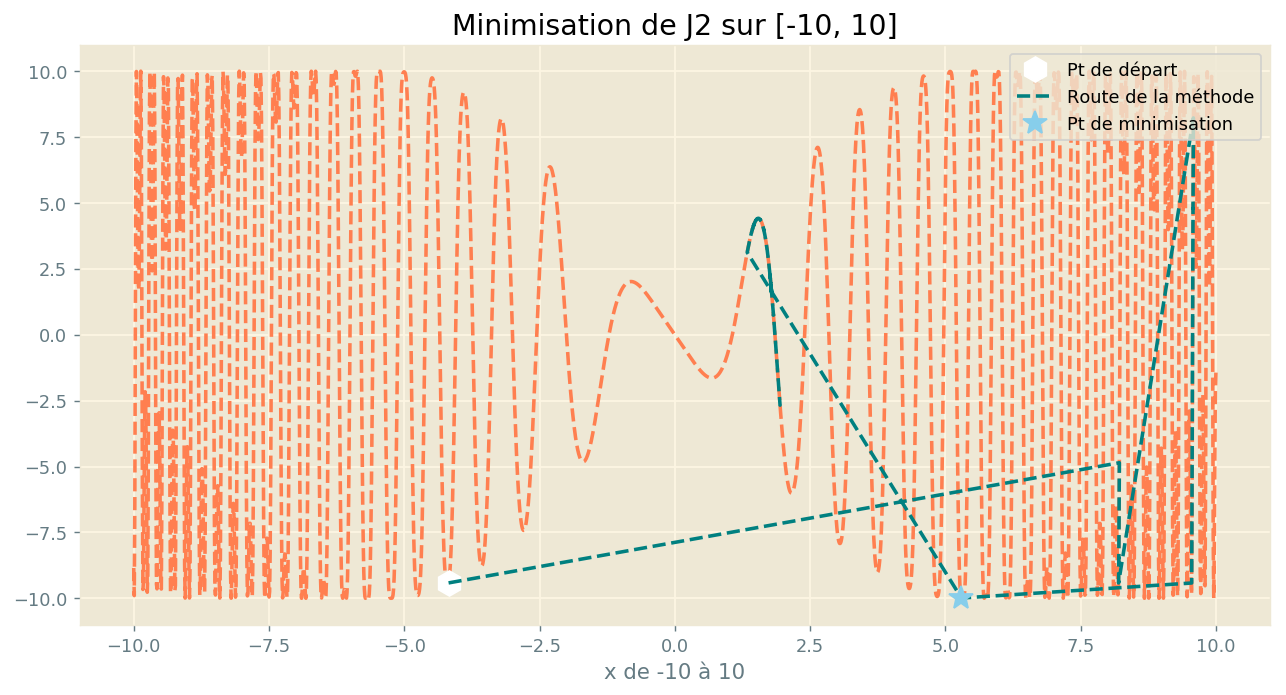

In [642]:
plotJ(J2, -10, 10, "Minimisation de J2 sur [-10, 10]")
plt.plot(routeX[0], routeJ[0], "h", color = 'white', 
         markersize = 14, label = "Pt de départ");
plt.plot(routeX, routeJ, "--", color = 'teal', label = "Route de la méthode");
plt.plot(bp, bval, "*", color = "skyblue", 
         markersize = 14, label = "Pt de minimisation");
plt.legend(loc="upper right");

In [643]:
print("Le minimum global"
      " est trouvé à Xmin = {:.2f}, J2(Xmin) = {:.2f}".format(bp, bval))

Le minimum global est trouvé à Xmin = 5.30, J2(Xmin) = -9.99


Point de départ:  1.7967247259109747
Le minimum global est trouvé à Xmin = 1.32, J2(Xmin) = 1.81


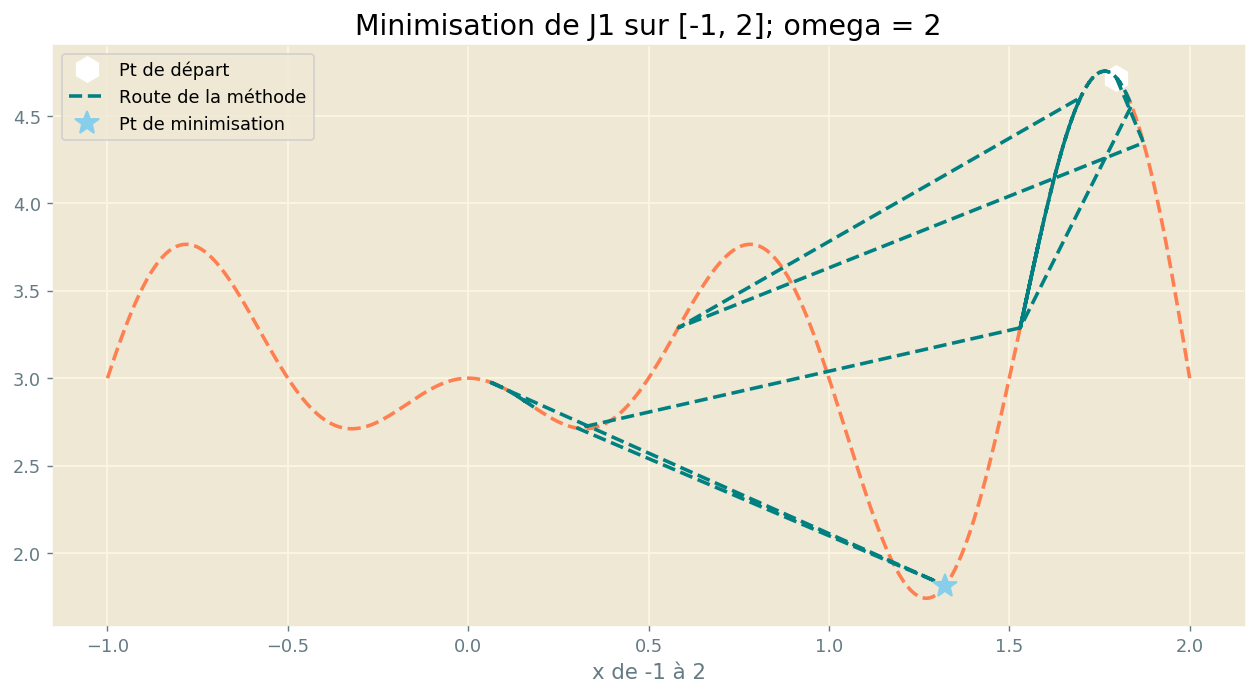

In [644]:
# test 1
omega = omegas[0]
bp, bval, routeX, routeJ = recuit(-1, 2, J1, T0 = 1e12, alpha = 1)

plotJ(J1, -1, 2, "Minimisation de J1 sur [-1, 2]; omega = {:d}".format(omega))

plt.plot(routeX[0], routeJ[0], "h", color = 'white', 
         markersize = 14, label = "Pt de départ");
plt.plot(routeX, routeJ, "--", color = 'teal', label = "Route de la méthode");
plt.plot(bp, bval, "*", color = "skyblue", 
         markersize = 14, label = "Pt de minimisation");
plt.legend();
print("Le minimum global est"
      " trouvé à Xmin = {:.2f}, J2(Xmin) = {:.2f}".format(bp, bval))

Point de départ:  1.3814945271318972
Le minimum global est trouvé à Xmin = -0.64, J2(Xmin) = 2.38


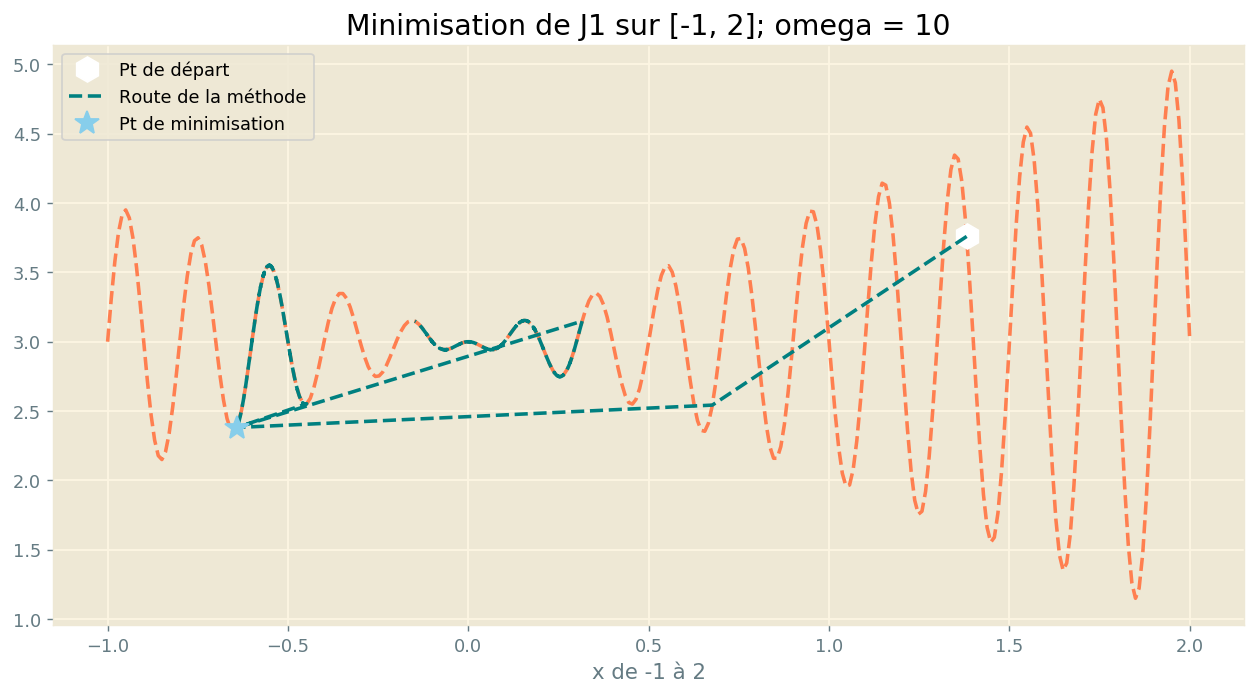

In [647]:
# test 2
omega = omegas[-1]
bp, bval, routeX, routeJ = recuit(-1, 2, J1, T0 = 1e404, alpha = 1)

plotJ(J1, -1, 2, "Minimisation de J1 sur [-1, 2]; omega = {:d}".format(omega))

plt.plot(routeX[0], routeJ[0], "h", color = 'white', 
         markersize = 14, label = "Pt de départ");
plt.plot(routeX, routeJ, "--", color = 'teal', label = "Route de la méthode");
plt.plot(bp, bval, "*", color = "skyblue", 
         markersize = 14, label = "Pt de minimisation");
plt.legend();
print("Le minimum global"
      " est trouvé à Xmin = {:.2f}, J2(Xmin) = {:.2f}".format(bp, bval))

Point de départ:  1.7733019364559213
Point de départ:  1.4520901145840317
Point de départ:  0.049920899362919435
Point de départ:  -0.7735875710900264
Point de départ:  1.7745826836915617
CPU times: user 1.42 s, sys: 20.9 ms, total: 1.44 s
Wall time: 1.45 s


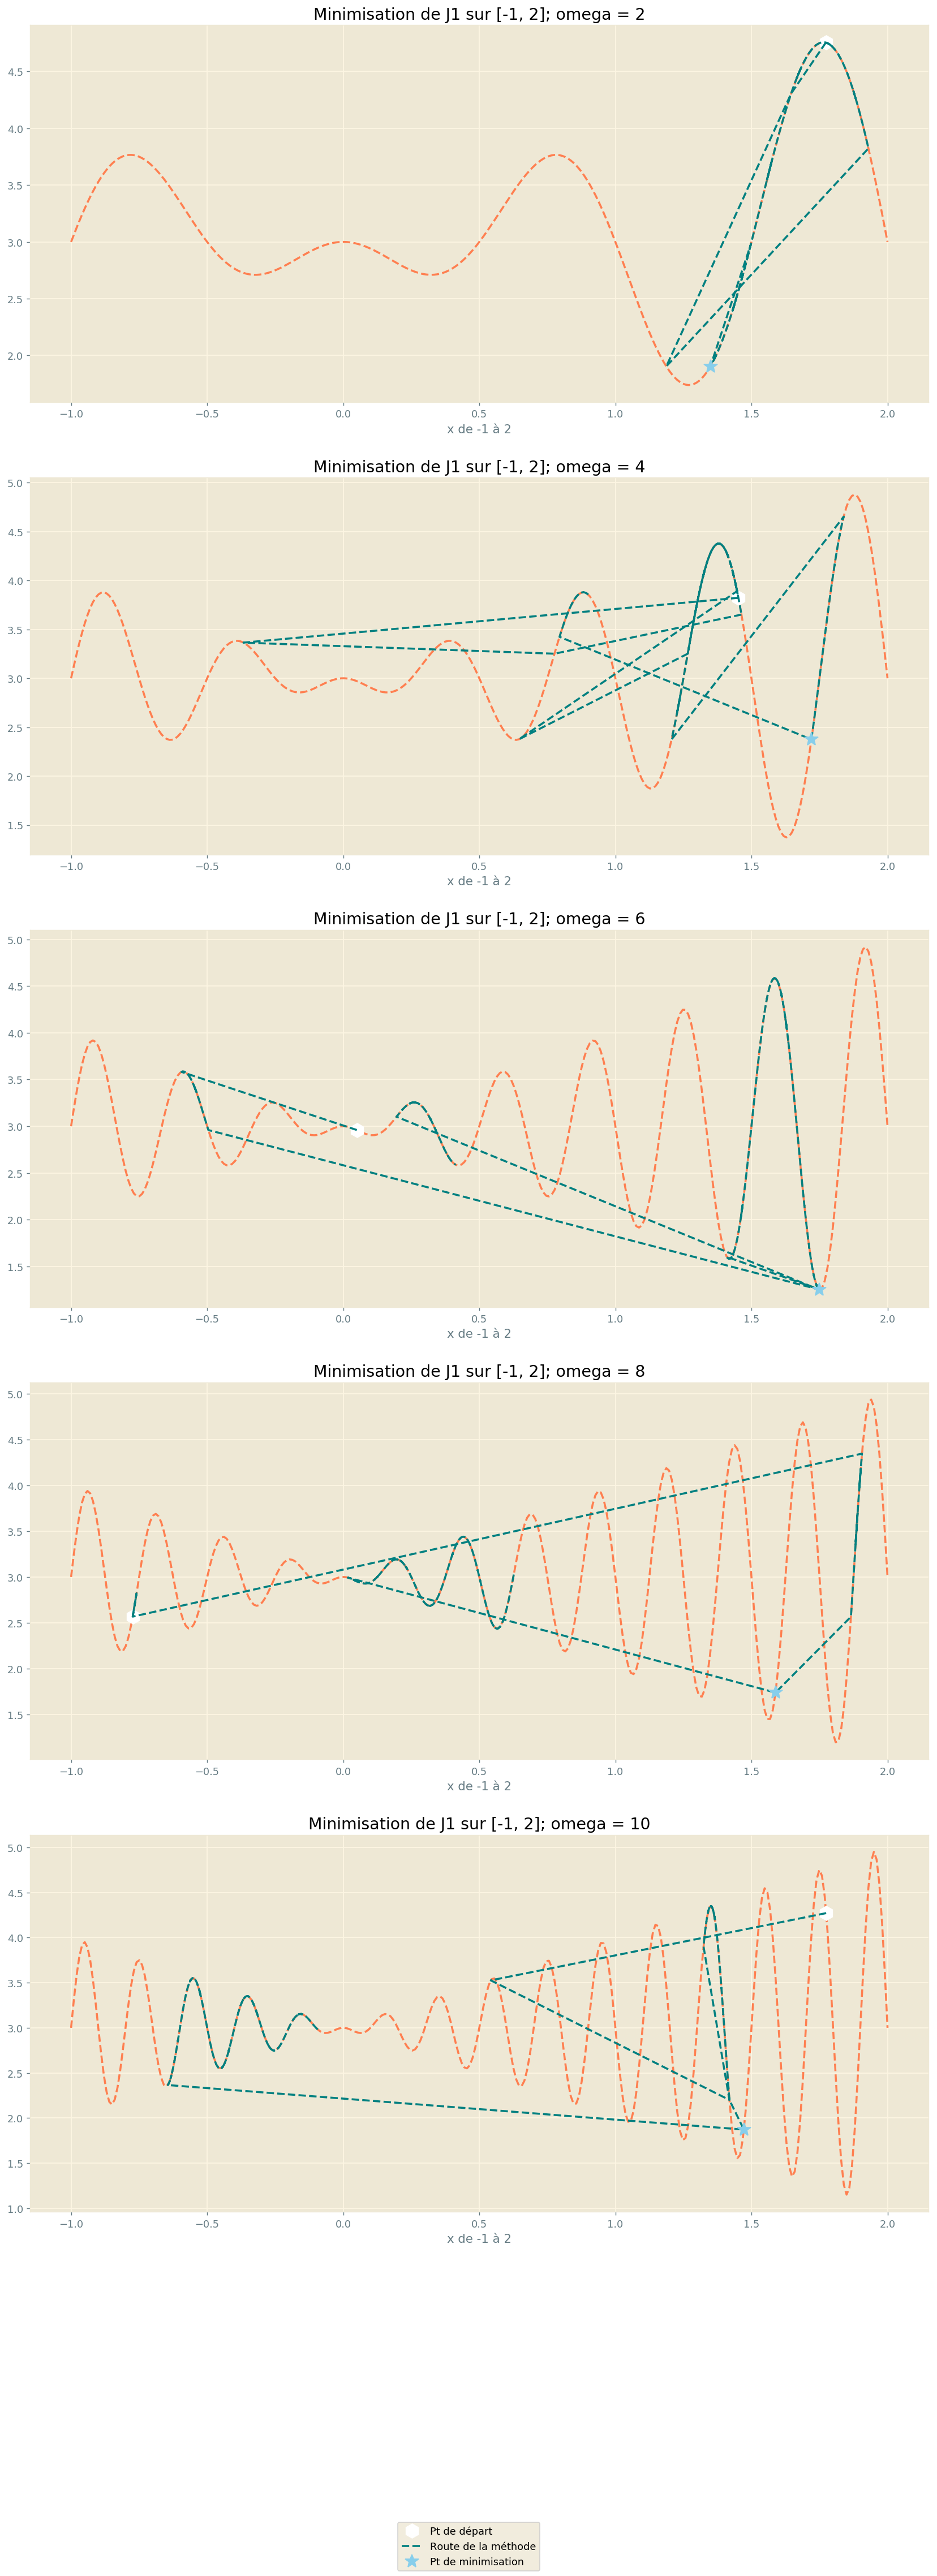

In [17]:
%%time
fig, axs = plt.subplots(len(omegas), 1, figsize = (16, 40), dpi = 128)
for i, o in enumerate(omegas):
    omega = o
    bp, bval, routeX, routeJ = recuit(-1, 2, J1, T0 = 1e404, alpha = 1)
    plotJ(J1, -1, 2, "Minimisation"
          " de J1 sur [-1, 2]; omega = {:d}".format(omega), ax = axs[i])
    axs[i].plot(routeX[0], routeJ[0], "h", color = 'white', 
                markersize = 14, label = "Pt de départ");
    axs[i].plot(routeX, routeJ, "--", 
                color = 'teal', label = "Route de la méthode");
    axs[i].plot(bp, bval, "*", 
                color = "skyblue", markersize = 14, label = "Pt de minimisation");

    
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center');

***Commentaire - 1:*** J'ai décidé de changer une ligne du code proposé, car l'algorithme n'a pas fonctionné comme je le pensais:
`xbis=max(x1,x-np.random.normal(0,0.1)*b)` pour `xbis=(x2-x1)*random.random()+x1`
Alors, l'algorithme est devenu encore plus instable, cependant, à mon avis, le résultat est plutôt irrésistible.

***Commentaire - 2:*** On peut remarquer que la méthode du recuit simulé est peut-être la plus instable de celles que nous avons étudiées. Cependant, dans certains cas, il est possible de trouver les résultats beaucoup plus utiles que les méthodes par gradients.

À mon avis, il serait très efficace d’utiliser la combinaison du recuit simulé et de la méthode du gradient car, comme nous l’avons vu, le recuit simulé n’atteint parfois pas le point exact du minimum local, ce qui est une tâche facile pour les méthodes du gradient.

In [626]:
#dérivé de J1
def dJ1(x):
    return -np.sin(omega*np.pi*x) - omega*np.pi*x*np.cos(omega*np.pi*x)

# gradient a pas fixe simple
def simple_grad(func, der, p, x0, epsilon=0.001, Iterations = 4004):
    # initialisation
    x_old = np.random.normal(size = N)
    x_new = x0
    i = 0
    routeF = np.array([func(x0)])
    routeX = np.array([x0])
    
    # la boucle principal
    while np.linalg.norm(x_old-x_new) > epsilon and i < Iterations:
        x_old = np.copy(x_new)           
        d = -1*der(x_old)
        x_new = x_old + p*d
        
        routeF = np.append(routeF, func(x_new))
        routeX = np.concatenate((routeX, [x_new]))
        i+=1
    
    return x_new, routeF, routeX

Point de départ:  0.162603102146198


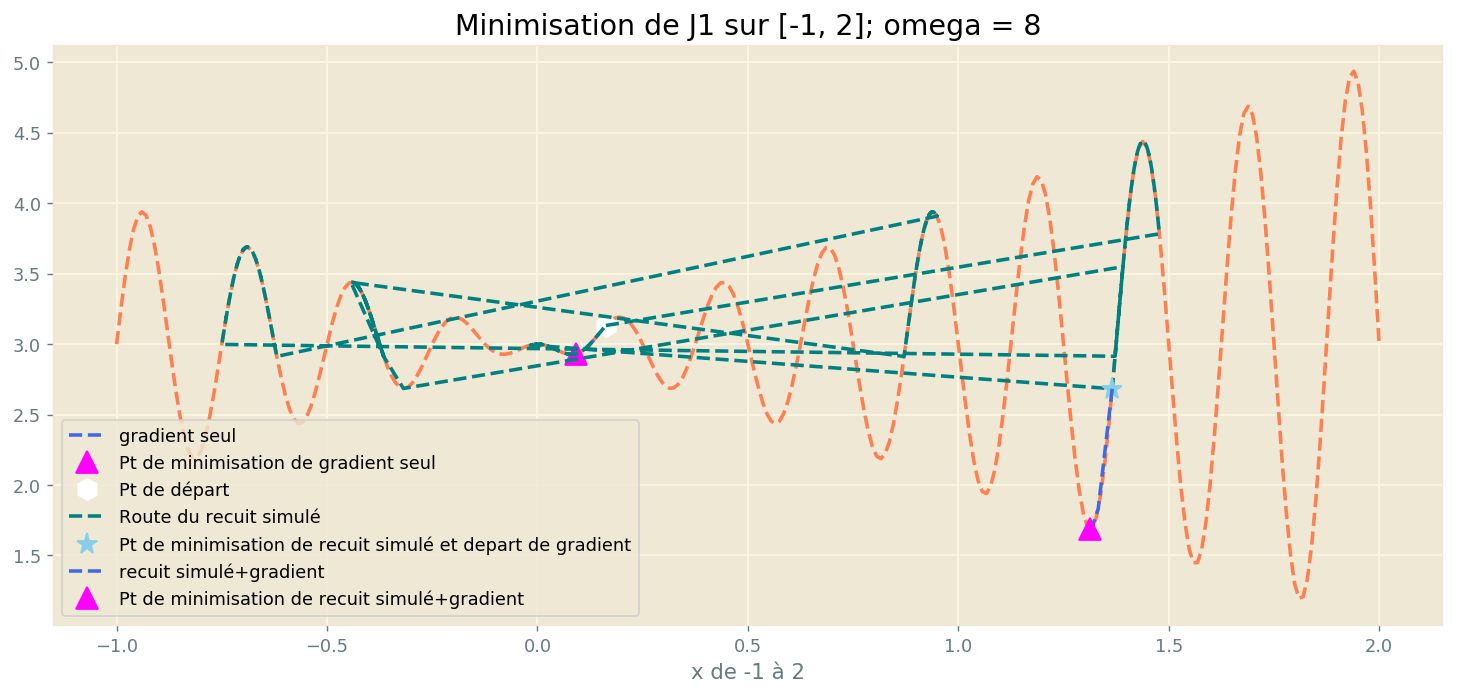

In [665]:
# petite demonstration
fig, axs = plt.subplots(figsize = (14, 6), dpi = 128)
omega = 8
bp, bval, routeX, routeJ = recuit(-1, 2, J1, T0 = 1e404, alpha = 1)

plotJ(J1, -1, 2, "Minimisation de J1 sur [-1, 2]; omega = {:d}".format(omega), ax=axs)

# gradient seul
Pgr_only, routeFgr_only, routeXgr_only = simple_grad(func=J1, 
                                                     der=dJ1, x0=routeX[0], p=0.001)
plt.plot(routeXgr_only, routeFgr_only, "--", 
         color = 'royalblue', label = "gradient seul");
plt.plot(routeXgr_only[-1], routeFgr_only[-1], "^", 
         color = "magenta", markersize = 12, 
         label = "Pt de minimisation de gradient seul");

# recuit simulé
plt.plot(routeX[0], routeJ[0], "h", 
         color = 'white', markersize = 12, label = "Pt de départ");
plt.plot(routeX, routeJ, "--", 
         color = 'teal', label = "Route du recuit simulé");
plt.plot(bp, bval, "*", color = "skyblue", markersize = 12, 
         label = "Pt de minimisation de recuit simulé et depart de gradient");

# recuit simulé+gradient
Pmin, routeF, routeXopt = simple_grad(func=J1, der=dJ1, x0=bp, p=0.001)
plt.plot(routeXopt, routeF, "--", 
         color = 'royalblue', label = "recuit simulé+gradient");
plt.plot(routeXopt[-1], routeF[-1], "^", color = "magenta", markersize = 12, 
         label = "Pt de minimisation de recuit simulé+gradient");

plt.legend(loc="lower left");

In [666]:
print("Min de gradient seul", routeFgr_only[-1])
print("Min de recuit simulé", bval)
print("Min de recuit simulé + gradient à pas fixe", routeF[-1])

Min de gradient seul 2.932498224284627
Min de recuit simulé 2.682871328072459
Min de recuit simulé + gradient à pas fixe 1.6869015912689385


***Commentaire:*** On voit bien que, simplement en ajoutant un gradient à pas fixe departant de la solution donnée par le recuit simulé, on peut "polir" la solution generale et obtenir le résultat un peu mieux.

- - -
- - -

# Conclusion

Nous avons vu et étudié de nombreuses méthodes d'optimisation avec et sans contraintes. On peut affirmer avec certitude qu’il n’existe pas de méthode «universelle» qui donnerait toujours la meilleure solution en un clin d’œil.

Certainement, on peut parfois comparer objectivement les performances des méthodes et dire que l’une est meilleure que l’autre. C’était le cas des gradients à pas fixe, de gradient à pas optimal et de gradient conjugué - nous avons confirmé qu’en général, un gradient à pas fixe est moins efficace que les deux derniers et sa convergence est plus faible (moins précise ou moins rapide).

En conclusion, il faut noter que les études sur la "banane" de Rosenbrock nous ont montré qu'il existe des fonctions particulières - difficiles à optimiser. De plus, les fonctions de types J1 et J2, qui étaient les cibles de l'optimisation dans la dernière partie, prouvaient que des méthodes parfois plus sophistiquées ou plutôt heuristiques étaient nécessaires pour trouver la meilleure solution.